DA6401 Assignment-1

NAME: MOUSINA BARMAN

ROLL: MA23M011



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m011 (ma23m011-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


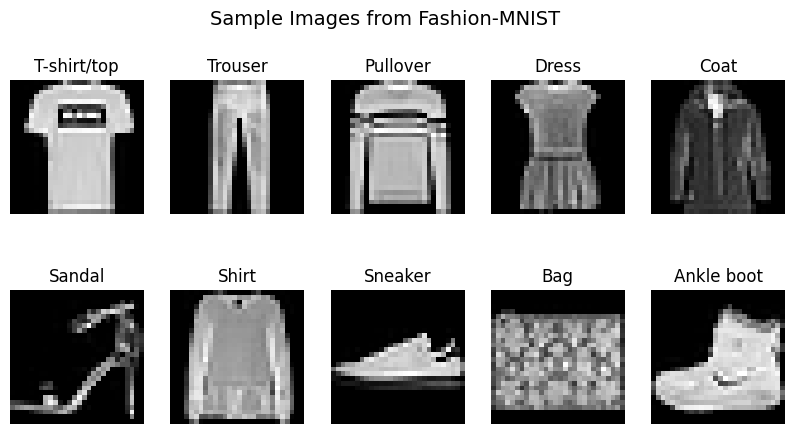

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from keras.datasets import fashion_mnist

# Initialize wandb
wandb.init(project="DA6401_Assignment1_ma23m011", name="sample-images-1")

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Define class labels for Fashion-MNIST
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Get one example of each class
sample_images = []
sample_labels = []
for class_id in range(10):
    idx = np.where(y_train == class_id)[0][0]  # Find first occurrence of class_id
    sample_images.append(x_train[idx])
    sample_labels.append(class_labels[class_id])

# Log images to wandb
wandb.log({"Sample Images": [wandb.Image(img, caption=label) for img, label in zip(sample_images, sample_labels)]})

# Plot images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Sample Images from Fashion-MNIST", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(sample_labels[i])
    ax.axis("off")

plt.show()

# Finish wandb run
wandb.finish()


In [2]:
# # Normalize the input images (scale pixel values to [0,1])
# x_train = x_train.reshape(x_train.shape[0], -1) / 255.0  # Flatten 28x28 images to 784-dim vector
# x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# # Convert labels to one-hot encoding
# def one_hot_encode(y, num_classes=10):
#     one_hot = np.zeros((y.size, num_classes))
#     one_hot[np.arange(y.size), y] = 1
#     return one_hot

# y_train = one_hot_encode(y_train)
# y_val = one_hot_encode(y_val)
# y_test = one_hot_encode(y_test)
# # Print to verify
# print("y_train shape:", y_train.shape)  # (54000, 10)
# print("y_val shape:", y_val.shape)      # (6000, 10)
# print("y_test shape:", y_test.shape)      # (10000, 10)

# # Define the Feedforward Neural Network class
# class NeuralNetwork:
#     def __init__(self, input_size=784, hidden_layers=[128, 64], output_size=10):
#         """
#         Initializes a fully connected neural network.
#         Parameters:
#             input_size (int): Number of input neurons (784 for Fashion-MNIST).
#             hidden_layers (list): List containing the number of neurons in each hidden layer.
#             output_size (int): Number of output neurons (10 for classification).
#         """
#         self.layers = [input_size] + hidden_layers + [output_size]  # Layers including input & output
#         self.weights = []
#         self.biases = []

#         # Initialize weights and biases
#         for i in range(len(self.layers) - 1):
#             self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)
#             self.biases.append(np.zeros((1, self.layers[i+1])))

#     def sigmoid(self, z):
#         z = np.clip(z, -500, 500)  # Prevent extreme values
#         return 1 / (1 + np.exp(-z))

#     def softmax(self, z):
#         exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability trick
#         return exp_z / np.sum(exp_z, axis=1, keepdims=True)

#     def forward(self, X):
#         """
#         Forward pass through the network.
#         Returns activations of all layers.
#         """
#         activations = [X]
#         for i in range(len(self.weights) - 1):
#             z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
#             a = self.sigmoid(z)
#             activations.append(a)

#         # Output layer (softmax activation)
#         z_out = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
#         a_out = self.softmax(z_out)
#         activations.append(a_out)

#         return activations

#     def predict(self, X):
#         """
#         Predict class labels for given input.
#         """
#         output = self.forward(X)[-1]
#         return np.argmax(output, axis=1)


# # Create a neural network with a flexible architecture
# nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10)

# # Forward pass example
# sample_input = x_train[:5]  # Take 5 sample images
# output_probs = nn.forward(sample_input)[-1]  # Get output probability distribution

# # Print predictions
# print("Predicted class probabilities:\n", output_probs)
# print("Predicted classes:", np.argmax(output_probs, axis=1))


In [3]:
import numpy as np
from keras.datasets import fashion_mnist

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize and flatten images
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# Create validation set (last 6000 samples from training set)
x_val = x_train[54000:]
y_val = y_train[54000:]

# Use the first 54,000 samples for training
x_train = x_train[:54000]
y_train = y_train[:54000]

# Convert labels to one-hot encoding
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

# ------------------------------ Neural Network Class --------------------------------------
class NeuralNetwork:
    def __init__(self, input_size=784, hidden_layers=[128, 64], output_size=10,
                 learning_rate=0.01, optimizer="sgd", weight_init="random",
                 activation="sigmoid", weight_decay=0.0):
        """
        Flexible Feedforward Neural Network with:
        - Weight Initialization: 'random' or 'xavier'
        - Activation Functions: 'sigmoid', 'tanh', 'relu'
        - Weight Decay (L2 Regularization): 0, 0.0005, 0.5
        """
        self.layers = [input_size] + hidden_layers + [output_size]
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.activation = activation
        self.weight_decay = weight_decay
        self.init_weights()

        # Optimizer-specific variables
        self.momentum = 0.9
        self.beta1 = 0.9  # Adam/Nadam
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.velocity = [np.zeros_like(w) for w in self.weights]
        self.squared_grads = [np.zeros_like(w) for w in self.weights]
        self.m = [np.zeros_like(w) for w in self.weights]
        self.v = [np.zeros_like(w) for w in self.weights]
        self.t = 0  # Time step

    def init_weights(self):
        """ Initialize weights and biases based on chosen method. """
        self.weights = []
        self.biases = []
        for i in range(len(self.layers) - 1):
            if self.weight_init == "random":
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)
            elif self.weight_init == "xavier":
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(1 / self.layers[i]))
            self.biases.append(np.zeros((1, self.layers[i+1])))

    def activation_function(self, z):
        """ Compute activation function based on user choice. """
        if self.activation == "sigmoid":
            return 1 / (1 + np.exp(-np.clip(z, -10, 10)))  # Prevent overflow
        elif self.activation == "tanh":
            return np.tanh(z)
        elif self.activation == "relu":
            return np.maximum(0, z)

    def activation_derivative(self, a):
        """ Compute derivative of activation function. """
        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        """ Forward pass through the network. """
        activations = [X]
        z_values = []

        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)
            activations.append(self.activation_function(z))

        z_out = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        z_values.append(z_out)
        activations.append(self.softmax(z_out))

        return activations, z_values

    def compute_loss(self, y_true, y_pred):
        """ Compute cross-entropy loss with optional L2 regularization. """
        loss = -np.sum(y_true * np.log(y_pred + self.epsilon)) / y_true.shape[0]
        l2_penalty = self.weight_decay * sum(np.sum(w**2) for w in self.weights) / 2
        return loss + l2_penalty

    def compute_accuracy(self, y_true, y_pred):
        """ Compute accuracy by comparing true vs predicted labels. """
        correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
        return correct_predictions / y_true.shape[0]

    def backward(self, X, y_true, activations, z_values):
        """ Backpropagation to compute gradients. """
        gradients_w = [np.zeros_like(w) for w in self.weights]
        gradients_b = [np.zeros_like(b) for b in self.biases]

        # Output layer gradient
        dL_dz = activations[-1] - y_true
        gradients_w[-1] = np.dot(activations[-2].T, dL_dz) + self.weight_decay * self.weights[-1]
        gradients_b[-1] = np.sum(dL_dz, axis=0, keepdims=True)

        # Hidden layers
        for i in reversed(range(len(self.weights) - 1)):
            dL_dz = np.dot(dL_dz, self.weights[i+1].T) * self.activation_derivative(activations[i+1])
            gradients_w[i] = np.dot(activations[i].T, dL_dz) + self.weight_decay * self.weights[i]
            gradients_b[i] = np.sum(dL_dz, axis=0, keepdims=True)

        return gradients_w, gradients_b

    def update_weights(self, gradients_w, gradients_b):
        """ Apply gradient updates using different optimizers. """
        self.t += 1  # Update time step for Adam/Nadam

        for i in range(len(self.weights)):
            if self.optimizer == "sgd":
                self.weights[i] -= self.learning_rate * gradients_w[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]

            elif self.optimizer == "momentum":
                self.velocity[i] = self.momentum * self.velocity[i] - self.learning_rate * gradients_w[i]
                self.weights[i] += self.velocity[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]

            elif self.optimizer == "nesterov":
                temp_weights = self.weights[i] + self.momentum * self.velocity[i]
                self.velocity[i] = self.momentum * self.velocity[i] - self.learning_rate * gradients_w[i]
                self.weights[i] = temp_weights + self.velocity[i]

            elif self.optimizer == "rmsprop":
                self.squared_grads[i] = 0.9 * self.squared_grads[i] + 0.1 * (gradients_w[i] ** 2)
                self.weights[i] -= self.learning_rate * gradients_w[i] / (np.sqrt(self.squared_grads[i]) + self.epsilon)

            elif self.optimizer == "adam":
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gradients_w[i]
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (gradients_w[i] ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            elif self.optimizer == "nadam":
                m_hat = (self.beta1 * self.m[i] + (1 - self.beta1) * gradients_w[i]) / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                self.weights[i] -= self.learning_rate * (self.momentum * m_hat + (1 - self.momentum) * gradients_w[i]) / (np.sqrt(v_hat) + self.epsilon)

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        """ Train the network using mini-batch gradient descent and track accuracy. """
        num_samples = X_train.shape[0]

        for epoch in range(epochs):
            # Shuffle training data
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_train, y_train = X_train[indices], y_train[indices]

            # Mini-batch training
            for i in range(0, num_samples, batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                # Forward pass
                activations, z_values = self.forward(X_batch)

                # Compute gradients
                gradients_w, gradients_b = self.backward(X_batch, y_batch, activations, z_values)

                # Update weights
                self.update_weights(gradients_w, gradients_b)

            # Compute training loss & accuracy
            train_activations, _ = self.forward(X_train)
            Train_loss = self.compute_loss(y_train, train_activations[-1])
            Train_accuracy = compute_accuracy(y_train, train_activations[-1])

            # Compute validation loss & accuracy
            val_activations, _ = self.forward(X_val)
            Val_loss = self.compute_loss(y_val, val_activations[-1])
            Val_accuracy = compute_accuracy(y_val, val_activations[-1])
            wandb.log({'Train_loss': Train_loss})
            wandb.log({'Train_accuracy': Train_accuracy })
            wandb.log({'epoch': epoch + 1})
            wandb.log({'Val_loss': Val_loss})
            wandb.log({'Val_accuracy': Val_accuracy })

            print(f"Epoch {epoch+1}: Train Loss = {Train_loss:.4f}, Train Acc = {Train_accuracy:.4f}, Val Loss = {Val_loss:.4f}, Val Acc = {Val_accuracy:.4f}")

def compute_accuracy(y_true, y_pred):
        """ Compute accuracy by comparing true vs predicted labels. """
        correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
        accuracy = correct_predictions / y_true.shape[0]
        return accuracy*100

In [4]:
# # Flatten both training and validation sets
# x_train = x_train.reshape(x_train.shape[0], -1)  # (54000, 784)
# x_val = x_val.reshape(x_val.shape[0], -1)  # (6000, 784)

# # Create Neural Network
# nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10, learning_rate=0.01, optimizer="sgd", weight_init="xavier", activation="relu", weight_decay=0.0005)

# # Train the model and track accuracy
# nn.train(x_train, y_train, x_val, y_val, epochs=10, batch_size=32)


In [5]:
!pip install wandb

In [6]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [7]:
key = input('Enter your API:')
wandb.login(key=key)

Enter your API:580e769ee2f34eafdded556ce52aaf31c265ad3b


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
sweep_config = {
    'method': 'bayes',
    'name' : 'sweep cross entropy-3',
    'metric': {
      'name': 'Val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers':{
            'values':[3,4,5]
        },
         'hidden_size':{
            'values':[32,64,128]
        },
        'weight_decay':{
            'values':[0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            'values': ['rmsprop', 'nadam','adam', 'nag','mgd','sgd']
        },
        'batch_size':{
            'values':[16,32,64]
        },
        'weight_init': {
            'values': ['xavier','random']
        },
        'activation': {
            'values': ['relu','tanh','sigmoid']
        },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401_Assignment1_ma23m011')

Create sweep with ID: augzj4ot
Sweep URL: https://wandb.ai/ma23m011-iit-madras/DA6401_Assignment1_ma23m011/sweeps/augzj4ot


In [9]:
def main():
    with wandb.init() as run:
        run_name="-ac_"+wandb.config.activation+"-hs_"+str(wandb.config.hidden_size)+"-epc_"+str(wandb.config.epochs)+"-hl_"+str(wandb.config.hidden_layers)+"-regu_"+str(wandb.config.weight_decay)+"-eta_"+str(wandb.config.learning_rate)+"-optmz_"+wandb.config.optimizer+"-batch_"+str(wandb.config.batch_size)+"-wght_"+wandb.config.weight_init
        wandb.run.name=run_name
        nn = NeuralNetwork(input_size=784, hidden_layers=[wandb.config.hidden_size] * wandb.config.hidden_layers, output_size=10, learning_rate=wandb.config.learning_rate, optimizer=wandb.config.optimizer, weight_init=wandb.config.weight_init, activation=wandb.config.activation, weight_decay=wandb.config.weight_decay)
        nn.train(x_train, y_train, x_val, y_val, epochs=wandb.config.epochs, batch_size=wandb.config.batch_size)


# # Create Neural Network
# nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10, learning_rate=0.01, optimizer="sgd")

# # Train the model and track accuracy
# nn.train(x_train, y_train, x_val, y_val, epochs=10, batch_size=32)

wandb.agent(sweep_id, function=main,count=100) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: b9eeqx07 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 16.5732, Train Acc = 10.0296, Val Loss = 16.6277, Val Acc = 9.7333
Epoch 2: Train Loss = 16.5841, Train Acc = 9.9704, Val Loss = 16.5295, Val Acc = 10.2667
Epoch 3: Train Loss = 16.5851, Train Acc = 9.9648, Val Loss = 16.5203, Val Acc = 10.3167
Epoch 4: Train Loss = 16.5803, Train Acc = 9.9907, Val Loss = 16.5633, Val Acc = 10.0833
Epoch 5: Train Loss = 16.5633, Train Acc = 10.0833, Val Loss = 16.7168, Val Acc = 9.2500


Train_accuracy,▅▁▁▃█
Train_loss,▄██▆▁
Val_accuracy,▄██▆▁
Val_loss,▅▁▁▃█
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,16.56326
Val_accuracy,9.25
Val_loss,16.71677
epoch,5


wandb: Agent Starting Run: ir7t8tx5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 3: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 4: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Train_loss,█▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,█▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,2.30258
Val_accuracy,10.5
Val_loss,2.30258
epoch,5


wandb: Agent Starting Run: 2y9qsm38 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.8493, Train Acc = 79.9093, Val Loss = 0.8512, Val Acc = 79.8667
Epoch 2: Train Loss = 0.8044, Train Acc = 84.9593, Val Loss = 0.8130, Val Acc = 84.1833
Epoch 3: Train Loss = 0.8007, Train Acc = 87.1019, Val Loss = 0.8175, Val Acc = 86.0500
Epoch 4: Train Loss = 0.8099, Train Acc = 87.9870, Val Loss = 0.8348, Val Acc = 86.7167
Epoch 5: Train Loss = 0.8324, Train Acc = 88.1056, Val Loss = 0.8647, Val Acc = 86.7833
Epoch 6: Train Loss = 0.8480, Train Acc = 88.5407, Val Loss = 0.8846, Val Acc = 86.9000
Epoch 7: Train Loss = 0.8590, Train Acc = 89.3278, Val Loss = 0.8994, Val Acc = 87.6500
Epoch 8: Train Loss = 0.8798, Train Acc = 89.1074, Val Loss = 0.9228, Val Acc = 87.3333
Epoch 9: Train Loss = 0.9007, Train Acc = 89.3444, Val Loss = 0.9399, Val Acc = 88.2333
Epoch 10: Train Loss = 0.9004, Train Acc = 90.3833, Val Loss = 0.9500, Val Acc = 88.4667


Train_accuracy,▁▄▆▆▆▇▇▇▇█
Train_loss,▄▁▁▂▃▄▅▇██
Val_accuracy,▁▅▆▇▇▇▇▇██
Val_loss,▃▁▁▂▄▅▅▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,90.38333
Train_loss,0.9004
Val_accuracy,88.46667
Val_loss,0.95004
epoch,10


wandb: Agent Starting Run: qdf7xw8l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 14.9390, Train Acc = 9.9389, Val Loss = 14.8554, Val Acc = 10.5500
Epoch 2: Train Loss = 13.2379, Train Acc = 10.0167, Val Loss = 13.0999, Val Acc = 9.8500
Epoch 3: Train Loss = 13.2379, Train Acc = 9.9648, Val Loss = 13.0999, Val Acc = 10.3167
Epoch 4: Train Loss = 13.2379, Train Acc = 9.9648, Val Loss = 13.1001, Val Acc = 10.3167
Epoch 5: Train Loss = 12.2265, Train Acc = 9.9648, Val Loss = 12.1185, Val Acc = 10.3167
Epoch 6: Train Loss = 11.6013, Train Acc = 10.0167, Val Loss = 11.5162, Val Acc = 9.8500
Epoch 7: Train Loss = 10.1418, Train Acc = 9.9648, Val Loss = 10.0512, Val Acc = 10.3167
Epoch 8: Train Loss = 10.0242, Train Acc = 9.9963, Val Loss = 9.9337, Val Acc = 10.0333
Epoch 9: Train Loss = 9.9974, Train Acc = 10.0167, Val Loss = 9.9090, Val Acc = 9.8500
Epoch 10: Train Loss = 8.7797, Train Acc = 9.9389, Val Loss = 8.7695, Val Acc = 10.5500


Train_accuracy,▁█▃▃▃█▃▆█▁
Train_loss,█▆▆▆▅▄▃▂▂▁
Val_accuracy,█▁▆▆▆▁▆▃▁█
Val_loss,█▆▆▆▅▄▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.93889
Train_loss,8.77965
Val_accuracy,10.55
Val_loss,8.76946
epoch,10


wandb: Agent Starting Run: 7x0tpzgt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3204, Train Acc = 19.8556, Val Loss = 2.3203, Val Acc = 20.3000
Epoch 2: Train Loss = 1.9835, Train Acc = 20.1056, Val Loss = 1.9863, Val Acc = 19.2167
Epoch 3: Train Loss = 1.9554, Train Acc = 22.6704, Val Loss = 1.9584, Val Acc = 21.9667
Epoch 4: Train Loss = 1.9284, Train Acc = 29.5500, Val Loss = 1.9311, Val Acc = 29.6333
Epoch 5: Train Loss = 1.9223, Train Acc = 29.6759, Val Loss = 1.9265, Val Acc = 28.5000
Epoch 6: Train Loss = 1.9264, Train Acc = 29.5259, Val Loss = 1.9299, Val Acc = 28.8833
Epoch 7: Train Loss = 1.8904, Train Acc = 29.7870, Val Loss = 1.8930, Val Acc = 30.3333
Epoch 8: Train Loss = 1.5623, Train Acc = 54.0593, Val Loss = 1.5582, Val Acc = 54.9833
Epoch 9: Train Loss = 1.3734, Train Acc = 68.7778, Val Loss = 1.3893, Val Acc = 68.9333
Epoch 10: Train Loss = 1.2952, Train Acc = 76.2389, Val Loss = 1.3197, Val Acc = 75.2333


Train_accuracy,▁▁▁▂▂▂▂▅▇█
Train_loss,█▆▆▅▅▅▅▃▂▁
Val_accuracy,▁▁▁▂▂▂▂▅▇█
Val_loss,█▆▅▅▅▅▅▃▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,76.23889
Train_loss,1.2952
Val_accuracy,75.23333
Val_loss,1.31968
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u8fglj5r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.4133, Train Acc = 53.8148, Val Loss = 1.4072, Val Acc = 54.9000
Epoch 2: Train Loss = 0.9651, Train Acc = 63.9444, Val Loss = 0.9536, Val Acc = 64.8500
Epoch 3: Train Loss = 0.7570, Train Acc = 72.5148, Val Loss = 0.7499, Val Acc = 72.9500
Epoch 4: Train Loss = 0.6458, Train Acc = 75.4852, Val Loss = 0.6409, Val Acc = 75.9500
Epoch 5: Train Loss = 0.5911, Train Acc = 77.1648, Val Loss = 0.5876, Val Acc = 77.5667
Epoch 6: Train Loss = 0.5560, Train Acc = 78.4796, Val Loss = 0.5532, Val Acc = 78.3833
Epoch 7: Train Loss = 0.5295, Train Acc = 79.8130, Val Loss = 0.5308, Val Acc = 79.6667
Epoch 8: Train Loss = 0.5134, Train Acc = 80.8019, Val Loss = 0.5165, Val Acc = 80.4167
Epoch 9: Train Loss = 0.4935, Train Acc = 81.8722, Val Loss = 0.5002, Val Acc = 81.1833
Epoch 10: Train Loss = 0.4774, Train Acc = 82.6833, Val Loss = 0.4816, Val Acc = 81.9000


Train_accuracy,▁▃▆▆▇▇▇███
Train_loss,█▅▃▂▂▂▁▁▁▁
Val_accuracy,▁▄▆▆▇▇▇███
Val_loss,█▅▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,82.68333
Train_loss,0.47744
Val_accuracy,81.9
Val_loss,0.48161
epoch,10


wandb: Agent Starting Run: 61qrhu8c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3028, Train Acc = 10.0833, Val Loss = 2.3037, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3027, Train Acc = 10.0167, Val Loss = 2.3028, Val Acc = 9.8500
Epoch 3: Train Loss = 2.3027, Train Acc = 9.9389, Val Loss = 2.3024, Val Acc = 10.5500
Epoch 4: Train Loss = 2.3026, Train Acc = 10.0167, Val Loss = 2.3029, Val Acc = 9.8500
Epoch 5: Train Loss = 2.3027, Train Acc = 10.0296, Val Loss = 2.3028, Val Acc = 9.7333


Train_accuracy,█▅▁▅▅
Train_loss,█▂▅▁▂
Val_accuracy,▁▄█▄▄
Val_loss,█▃▁▄▃
epoch,▁▃▅▆█
Train_accuracy,10.02963
Train_loss,2.30268
Val_accuracy,9.73333
Val_loss,2.30281
epoch,5


wandb: Agent Starting Run: lb5eieud with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3083, Train Acc = 9.9389, Val Loss = 2.3079, Val Acc = 10.5500
Epoch 2: Train Loss = 2.3083, Train Acc = 9.9389, Val Loss = 2.3079, Val Acc = 10.5500
Epoch 3: Train Loss = 2.3083, Train Acc = 9.9389, Val Loss = 2.3079, Val Acc = 10.5500
Epoch 4: Train Loss = 2.3083, Train Acc = 9.9389, Val Loss = 2.3079, Val Acc = 10.5500
Epoch 5: Train Loss = 2.3083, Train Acc = 9.9389, Val Loss = 2.3079, Val Acc = 10.5500
Epoch 6: Train Loss = 2.3083, Train Acc = 9.9389, Val Loss = 2.3079, Val Acc = 10.5500
Epoch 7: Train Loss = 2.3083, Train Acc = 9.9389, Val Loss = 2.3079, Val Acc = 10.5500
Epoch 8: Train Loss = 2.3083, Train Acc = 9.9389, Val Loss = 2.3079, Val Acc = 10.5500
Epoch 9: Train Loss = 2.3083, Train Acc = 9.9389, Val Loss = 2.3079, Val Acc = 10.5500
Epoch 10: Train Loss = 2.3083, Train Acc = 9.9389, Val Loss = 2.3079, Val Acc = 10.5500


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.93889
Train_loss,2.30828
Val_accuracy,10.55
Val_loss,2.30795
epoch,10


wandb: Agent Starting Run: e2sakmmz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: 6apnc971 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 10.8204, Val Loss = 2.3026, Val Acc = 10.8833
Epoch 2: Train Loss = 2.3026, Train Acc = 10.8185, Val Loss = 2.3026, Val Acc = 10.8833
Epoch 3: Train Loss = 2.3026, Train Acc = 10.8167, Val Loss = 2.3026, Val Acc = 10.8833
Epoch 4: Train Loss = 2.3026, Train Acc = 10.8111, Val Loss = 2.3026, Val Acc = 10.8833
Epoch 5: Train Loss = 2.3026, Train Acc = 10.8185, Val Loss = 2.3026, Val Acc = 10.8833
Epoch 6: Train Loss = 2.3026, Train Acc = 10.8130, Val Loss = 2.3026, Val Acc = 10.8833
Epoch 7: Train Loss = 2.3026, Train Acc = 10.8185, Val Loss = 2.3026, Val Acc = 10.8833
Epoch 8: Train Loss = 2.3026, Train Acc = 10.8111, Val Loss = 2.3026, Val Acc = 10.8833
Epoch 9: Train Loss = 2.3026, Train Acc = 10.8093, Val Loss = 2.3026, Val Acc = 10.8833
Epoch 10: Train Loss = 2.3026, Train Acc = 10.8185, Val Loss = 2.3026, Val Acc = 10.8833


Train_accuracy,█▇▆▂▇▃▇▂▁▇
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.81852
Train_loss,2.30259
Val_accuracy,10.88333
Val_loss,2.30259
epoch,10


wandb: Agent Starting Run: 3df7lmn4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.6289, Train Acc = 74.9778, Val Loss = 0.6276, Val Acc = 74.7000
Epoch 2: Train Loss = 0.5327, Train Acc = 79.6685, Val Loss = 0.5405, Val Acc = 79.8500
Epoch 3: Train Loss = 0.4782, Train Acc = 81.2852, Val Loss = 0.5051, Val Acc = 80.9000
Epoch 4: Train Loss = 0.4394, Train Acc = 82.3111, Val Loss = 0.4706, Val Acc = 81.8500
Epoch 5: Train Loss = 0.4648, Train Acc = 81.8333, Val Loss = 0.4973, Val Acc = 81.7167
Epoch 6: Train Loss = 0.3399, Train Acc = 87.5000, Val Loss = 0.3888, Val Acc = 85.7833
Epoch 7: Train Loss = 0.3338, Train Acc = 87.7778, Val Loss = 0.3958, Val Acc = 86.1500
Epoch 8: Train Loss = 0.3321, Train Acc = 88.3833, Val Loss = 0.4010, Val Acc = 86.6000
Epoch 9: Train Loss = 0.3040, Train Acc = 88.8389, Val Loss = 0.3726, Val Acc = 87.3000
Epoch 10: Train Loss = 0.2874, Train Acc = 89.5370, Val Loss = 0.3828, Val Acc = 87.6333


Train_accuracy,▁▃▄▅▄▇▇▇██
Train_loss,█▆▅▄▅▂▂▂▁▁
Val_accuracy,▁▄▄▅▅▇▇▇██
Val_loss,█▆▅▄▄▁▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,89.53704
Train_loss,0.28739
Val_accuracy,87.63333
Val_loss,0.38278
epoch,10


wandb: Agent Starting Run: h0krfs6o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.4368, Train Acc = 50.1222, Val Loss = 1.4263, Val Acc = 51.0500
Epoch 2: Train Loss = 1.1664, Train Acc = 66.2815, Val Loss = 1.1557, Val Acc = 66.9167
Epoch 3: Train Loss = 1.0308, Train Acc = 74.6926, Val Loss = 1.0317, Val Acc = 75.2333
Epoch 4: Train Loss = 0.9689, Train Acc = 77.5222, Val Loss = 0.9756, Val Acc = 77.6000
Epoch 5: Train Loss = 0.9380, Train Acc = 78.7481, Val Loss = 0.9451, Val Acc = 78.9333
Epoch 6: Train Loss = 0.9257, Train Acc = 79.5019, Val Loss = 0.9357, Val Acc = 79.4833
Epoch 7: Train Loss = 0.9148, Train Acc = 80.4333, Val Loss = 0.9258, Val Acc = 80.3500
Epoch 8: Train Loss = 0.9031, Train Acc = 81.1093, Val Loss = 0.9174, Val Acc = 81.0167
Epoch 9: Train Loss = 0.8956, Train Acc = 81.5722, Val Loss = 0.9082, Val Acc = 81.2667
Epoch 10: Train Loss = 0.8930, Train Acc = 81.7444, Val Loss = 0.9031, Val Acc = 81.4333


Train_accuracy,▁▅▆▇▇█████
Train_loss,█▅▃▂▂▁▁▁▁▁
Val_accuracy,▁▅▇▇▇█████
Val_loss,█▄▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,81.74444
Train_loss,0.893
Val_accuracy,81.43333
Val_loss,0.90308
epoch,10


wandb: Agent Starting Run: a5nra6ex with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 10.4337, Train Acc = 71.2296, Val Loss = 10.4205, Val Acc = 71.5333
Epoch 2: Train Loss = 9.1059, Train Acc = 73.9389, Val Loss = 9.0955, Val Acc = 74.9167
Epoch 3: Train Loss = 8.9651, Train Acc = 74.4907, Val Loss = 8.9617, Val Acc = 74.3833
Epoch 4: Train Loss = 8.8555, Train Acc = 72.6574, Val Loss = 8.8487, Val Acc = 73.1333
Epoch 5: Train Loss = 8.8419, Train Acc = 74.0370, Val Loss = 8.8366, Val Acc = 74.7167


Train_accuracy,▁▇█▄▇
Train_loss,█▂▂▁▁
Val_accuracy,▁█▇▄█
Val_loss,█▂▂▁▁
epoch,▁▃▅▆█
Train_accuracy,74.03704
Train_loss,8.84189
Val_accuracy,74.71667
Val_loss,8.83656
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vnqilo8g with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.0930, Train Acc = 56.6222, Val Loss = 1.0724, Val Acc = 57.8167
Epoch 2: Train Loss = 0.7989, Train Acc = 70.2574, Val Loss = 0.7908, Val Acc = 70.9000
Epoch 3: Train Loss = 0.6860, Train Acc = 77.0889, Val Loss = 0.6836, Val Acc = 77.2167
Epoch 4: Train Loss = 0.5983, Train Acc = 79.7926, Val Loss = 0.6013, Val Acc = 79.6167
Epoch 5: Train Loss = 0.5855, Train Acc = 79.4852, Val Loss = 0.5986, Val Acc = 77.9500
Epoch 6: Train Loss = 0.5246, Train Acc = 81.7148, Val Loss = 0.5404, Val Acc = 80.1000
Epoch 7: Train Loss = 0.4967, Train Acc = 82.9296, Val Loss = 0.5081, Val Acc = 82.0500
Epoch 8: Train Loss = 0.4807, Train Acc = 83.0944, Val Loss = 0.5023, Val Acc = 82.2833
Epoch 9: Train Loss = 0.4568, Train Acc = 83.9463, Val Loss = 0.4754, Val Acc = 82.8333
Epoch 10: Train Loss = 0.4433, Train Acc = 84.4426, Val Loss = 0.4616, Val Acc = 83.3000


Train_accuracy,▁▄▆▇▇▇████
Train_loss,█▅▄▃▃▂▂▁▁▁
Val_accuracy,▁▅▆▇▇▇████
Val_loss,█▅▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,84.44259
Train_loss,0.44333
Val_accuracy,83.3
Val_loss,0.46156
epoch,10


wandb: Agent Starting Run: vnsvpdir with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.3547, Train Acc = 9.9963, Val Loss = 3.3546, Val Acc = 10.0333
Epoch 2: Train Loss = 3.0537, Train Acc = 10.0648, Val Loss = 3.0543, Val Acc = 9.4167
Epoch 3: Train Loss = 2.8384, Train Acc = 9.9963, Val Loss = 2.8384, Val Acc = 10.0333
Epoch 4: Train Loss = 2.6851, Train Acc = 10.0648, Val Loss = 2.6853, Val Acc = 9.4167
Epoch 5: Train Loss = 2.5755, Train Acc = 10.0648, Val Loss = 2.5753, Val Acc = 9.4167


Train_accuracy,▁█▁██
Train_loss,█▅▃▂▁
Val_accuracy,█▁█▁▁
Val_loss,█▅▃▂▁
epoch,▁▃▅▆█
Train_accuracy,10.06481
Train_loss,2.57553
Val_accuracy,9.41667
Val_loss,2.57534
epoch,5


wandb: Agent Starting Run: xwbvbwlx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 16.5633, Train Acc = 10.0833, Val Loss = 16.7168, Val Acc = 9.2500
Epoch 2: Train Loss = 14.8666, Train Acc = 10.0833, Val Loss = 14.9520, Val Acc = 9.2500
Epoch 3: Train Loss = 13.4326, Train Acc = 9.9648, Val Loss = 13.5033, Val Acc = 10.3167
Epoch 4: Train Loss = 11.6044, Train Acc = 10.0833, Val Loss = 11.6298, Val Acc = 9.2500
Epoch 5: Train Loss = 11.6044, Train Acc = 10.0833, Val Loss = 11.6298, Val Acc = 9.2500


Train_accuracy,██▁██
Train_loss,█▆▄▁▁
Val_accuracy,▁▁█▁▁
Val_loss,█▆▄▁▁
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,11.60443
Val_accuracy,9.25
Val_loss,11.62981
epoch,5


wandb: Agent Starting Run: 3om4hhs6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.9770, Train Acc = 9.6241, Val Loss = 3.9770, Val Acc = 9.4833
Epoch 2: Train Loss = 3.9770, Train Acc = 9.6241, Val Loss = 3.9770, Val Acc = 9.4833
Epoch 3: Train Loss = 3.9770, Train Acc = 9.6241, Val Loss = 3.9770, Val Acc = 9.4833
Epoch 4: Train Loss = 3.9770, Train Acc = 9.6241, Val Loss = 3.9770, Val Acc = 9.4833
Epoch 5: Train Loss = 3.9770, Train Acc = 9.6241, Val Loss = 3.9770, Val Acc = 9.4833
Epoch 6: Train Loss = 3.9770, Train Acc = 9.6241, Val Loss = 3.9770, Val Acc = 9.4833
Epoch 7: Train Loss = 3.9770, Train Acc = 9.6241, Val Loss = 3.9770, Val Acc = 9.4833
Epoch 8: Train Loss = 3.9770, Train Acc = 9.6241, Val Loss = 3.9770, Val Acc = 9.4833
Epoch 9: Train Loss = 3.9770, Train Acc = 9.6241, Val Loss = 3.9770, Val Acc = 9.4833
Epoch 10: Train Loss = 3.9770, Train Acc = 9.6241, Val Loss = 3.9770, Val Acc = 9.4833


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.62407
Train_loss,3.97698
Val_accuracy,9.48333
Val_loss,3.97698
epoch,10


wandb: Agent Starting Run: qdtaucap with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.6770, Train Acc = 83.7741, Val Loss = 0.7011, Val Acc = 82.6667
Epoch 2: Train Loss = 0.6567, Train Acc = 87.3333, Val Loss = 0.6913, Val Acc = 86.3333
Epoch 3: Train Loss = 0.6985, Train Acc = 86.5981, Val Loss = 0.7317, Val Acc = 85.6333
Epoch 4: Train Loss = 0.7150, Train Acc = 88.2222, Val Loss = 0.7618, Val Acc = 86.7167
Epoch 5: Train Loss = 0.7600, Train Acc = 87.7759, Val Loss = 0.8080, Val Acc = 86.3000


Train_accuracy,▁▇▅█▇
Train_loss,▂▁▄▅█
Val_accuracy,▁▇▆█▇
Val_loss,▂▁▃▅█
epoch,▁▃▅▆█
Train_accuracy,87.77593
Train_loss,0.75997
Val_accuracy,86.3
Val_loss,0.80799
epoch,5


wandb: Agent Starting Run: ijyu2b9f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 17.8489, Train Acc = 9.9389, Val Loss = 17.8484, Val Acc = 10.5500
Epoch 2: Train Loss = 11.2234, Train Acc = 9.9389, Val Loss = 11.2230, Val Acc = 10.5500
Epoch 3: Train Loss = 7.8055, Train Acc = 9.9389, Val Loss = 7.8053, Val Acc = 10.5500
Epoch 4: Train Loss = 6.0696, Train Acc = 10.0648, Val Loss = 6.0701, Val Acc = 9.4167
Epoch 5: Train Loss = 5.1803, Train Acc = 10.0648, Val Loss = 5.1807, Val Acc = 9.4167
Epoch 6: Train Loss = 4.6656, Train Acc = 10.0296, Val Loss = 4.6658, Val Acc = 9.7333
Epoch 7: Train Loss = 4.3255, Train Acc = 10.0167, Val Loss = 4.3260, Val Acc = 9.8500
Epoch 8: Train Loss = 4.0834, Train Acc = 10.0833, Val Loss = 4.0838, Val Acc = 9.2500
Epoch 9: Train Loss = 3.9008, Train Acc = 9.9648, Val Loss = 3.9009, Val Acc = 10.3167
Epoch 10: Train Loss = 3.7556, Train Acc = 10.0296, Val Loss = 3.7556, Val Acc = 9.7333


Train_accuracy,▁▁▁▇▇▅▅█▂▅
Train_loss,█▅▃▂▂▁▁▁▁▁
Val_accuracy,███▂▂▄▄▁▇▄
Val_loss,█▅▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.02963
Train_loss,3.75561
Val_accuracy,9.73333
Val_loss,3.75565
epoch,10


wandb: Agent Starting Run: r8hzu6fl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 20.8919, Train Acc = 9.9907, Val Loss = 20.8920, Val Acc = 10.0833
Epoch 2: Train Loss = 12.1324, Train Acc = 10.0833, Val Loss = 12.1328, Val Acc = 9.2500
Epoch 3: Train Loss = 7.9007, Train Acc = 9.9963, Val Loss = 7.9010, Val Acc = 10.0333
Epoch 4: Train Loss = 5.9582, Train Acc = 9.9704, Val Loss = 5.9586, Val Acc = 10.2667
Epoch 5: Train Loss = 5.0280, Train Acc = 10.0833, Val Loss = 5.0281, Val Acc = 9.2500
Epoch 6: Train Loss = 4.5213, Train Acc = 9.9704, Val Loss = 4.5212, Val Acc = 10.2667
Epoch 7: Train Loss = 4.1956, Train Acc = 9.9704, Val Loss = 4.1958, Val Acc = 10.2667
Epoch 8: Train Loss = 3.9670, Train Acc = 10.0296, Val Loss = 3.9673, Val Acc = 9.7333
Epoch 9: Train Loss = 3.7957, Train Acc = 9.9704, Val Loss = 3.7958, Val Acc = 10.2667
Epoch 10: Train Loss = 3.6625, Train Acc = 9.9648, Val Loss = 3.6626, Val Acc = 10.3167


Train_accuracy,▃█▃▁█▁▁▅▁▁
Train_loss,█▄▃▂▂▁▁▁▁▁
Val_accuracy,▆▁▆█▁██▄██
Val_loss,█▄▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.96481
Train_loss,3.66248
Val_accuracy,10.31667
Val_loss,3.66257
epoch,10


wandb: Agent Starting Run: 937mtij7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: 8nl223t5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 233109705.7213, Train Acc = 9.9648, Val Loss = 233109705.6784, Val Acc = 10.3167
Epoch 2: Train Loss = 3167526784577873903616.0000, Train Acc = 9.9907, Val Loss = 3167526784577873903616.0000, Val Acc = 10.0833
Epoch 3: Train Loss = 305664919490.4352, Train Acc = 9.9648, Val Loss = 305664919490.4416, Val Acc = 10.3167
Epoch 4: Train Loss = 4473.0382, Train Acc = 10.0833, Val Loss = 4473.0382, Val Acc = 9.2500
Epoch 5: Train Loss = 365548676804050.8125, Train Acc = 9.9704, Val Loss = 365548676804050.8125, Val Acc = 10.2667
Epoch 6: Train Loss = 4485.8656, Train Acc = 10.0167, Val Loss = 4485.8656, Val Acc = 9.8500
Epoch 7: Train Loss = 6506141028468828160.0000, Train Acc = 10.0296, Val Loss = 6506141028468828160.0000, Val Acc = 9.7333
Epoch 8: Train Loss = 225241272.8651, Train Acc = 9.9648, Val Loss = 225241272.8651, Val Acc = 10.3167
Epoch 9: Train Loss = 4958406117883385856.0000, Train Acc = 10.0833, Val Loss = 4958406117883385856.0000, Val Acc = 9.2500
Epoch 10:

Train_accuracy,▁▃▁█▁▄▅▁█▃
Train_loss,▁█▁▁▁▁▁▁▁▁
Val_accuracy,█▆█▁█▅▄█▁▆
Val_loss,▁█▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.99074
Train_loss,6.941787432248975e+16
Val_accuracy,10.08333
Val_loss,6.941787432248975e+16
epoch,10


wandb: Agent Starting Run: 59dqjtqz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3088, Train Acc = 9.9963, Val Loss = 2.3072, Val Acc = 10.0333
Epoch 2: Train Loss = 2.3088, Train Acc = 9.9963, Val Loss = 2.3072, Val Acc = 10.0333
Epoch 3: Train Loss = 2.3088, Train Acc = 9.9963, Val Loss = 2.3072, Val Acc = 10.0333
Epoch 4: Train Loss = 2.3088, Train Acc = 9.9963, Val Loss = 2.3072, Val Acc = 10.0333
Epoch 5: Train Loss = 2.3088, Train Acc = 9.9963, Val Loss = 2.3072, Val Acc = 10.0333
Epoch 6: Train Loss = 2.3088, Train Acc = 9.9963, Val Loss = 2.3072, Val Acc = 10.0333
Epoch 7: Train Loss = 2.3088, Train Acc = 9.9963, Val Loss = 2.3072, Val Acc = 10.0333
Epoch 8: Train Loss = 2.3088, Train Acc = 9.9963, Val Loss = 2.3072, Val Acc = 10.0333
Epoch 9: Train Loss = 2.3088, Train Acc = 9.9963, Val Loss = 2.3072, Val Acc = 10.0333
Epoch 10: Train Loss = 2.3088, Train Acc = 9.9963, Val Loss = 2.3072, Val Acc = 10.0333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.9963
Train_loss,2.3088
Val_accuracy,10.03333
Val_loss,2.30721
epoch,10


wandb: Agent Starting Run: 7qzf8lmi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


<ipython-input-3-b7f5dafee785>:89: RuntimeWarning: invalid value encountered in subtract
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: g5ko8pxz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.7300, Train Acc = 71.6778, Val Loss = 0.7227, Val Acc = 72.7000
Epoch 2: Train Loss = 0.5498, Train Acc = 79.2593, Val Loss = 0.5633, Val Acc = 79.5333
Epoch 3: Train Loss = 0.5740, Train Acc = 78.3019, Val Loss = 0.5977, Val Acc = 78.1333
Epoch 4: Train Loss = 0.4711, Train Acc = 82.9481, Val Loss = 0.4949, Val Acc = 82.1000
Epoch 5: Train Loss = 0.3975, Train Acc = 86.4389, Val Loss = 0.4296, Val Acc = 85.3000
Epoch 6: Train Loss = 0.3790, Train Acc = 86.1333, Val Loss = 0.4279, Val Acc = 85.4000
Epoch 7: Train Loss = 0.3389, Train Acc = 87.8111, Val Loss = 0.3973, Val Acc = 86.7000
Epoch 8: Train Loss = 0.3302, Train Acc = 88.0870, Val Loss = 0.3824, Val Acc = 86.0667
Epoch 9: Train Loss = 0.3019, Train Acc = 89.2093, Val Loss = 0.3600, Val Acc = 87.4333
Epoch 10: Train Loss = 0.3002, Train Acc = 88.8111, Val Loss = 0.3645, Val Acc = 87.4667


Train_accuracy,▁▄▄▆▇▇▇███
Train_loss,█▅▅▄▃▂▂▁▁▁
Val_accuracy,▁▄▄▅▇▇█▇██
Val_loss,█▅▆▄▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,88.81111
Train_loss,0.3002
Val_accuracy,87.46667
Val_loss,0.36451
epoch,10


wandb: Agent Starting Run: tbjuxbtc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3976, Train Acc = 20.0259, Val Loss = 2.3996, Val Acc = 19.2667
Epoch 2: Train Loss = 2.0854, Train Acc = 21.4704, Val Loss = 2.0887, Val Acc = 21.3000
Epoch 3: Train Loss = 2.0239, Train Acc = 28.1389, Val Loss = 2.0292, Val Acc = 28.8833
Epoch 4: Train Loss = 2.0082, Train Acc = 28.4426, Val Loss = 2.0152, Val Acc = 27.0333
Epoch 5: Train Loss = 1.9983, Train Acc = 30.1630, Val Loss = 2.0059, Val Acc = 29.6667
Epoch 6: Train Loss = 1.9913, Train Acc = 38.1500, Val Loss = 2.0005, Val Acc = 36.3000
Epoch 7: Train Loss = 2.0046, Train Acc = 38.6222, Val Loss = 2.0164, Val Acc = 37.5667
Epoch 8: Train Loss = 2.0095, Train Acc = 31.5259, Val Loss = 2.0240, Val Acc = 30.0167
Epoch 9: Train Loss = 1.6387, Train Acc = 54.6963, Val Loss = 1.6472, Val Acc = 55.7167
Epoch 10: Train Loss = 1.5688, Train Acc = 59.9037, Val Loss = 1.5836, Val Acc = 59.6500


Train_accuracy,▁▁▂▂▃▄▄▃▇█
Train_loss,█▅▅▅▅▅▅▅▂▁
Val_accuracy,▁▁▃▂▃▄▄▃▇█
Val_loss,█▅▅▅▅▅▅▅▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,59.9037
Train_loss,1.56876
Val_accuracy,59.65
Val_loss,1.58357
epoch,10


wandb: Agent Starting Run: ev2m18wx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.6432, Train Acc = 10.0648, Val Loss = 2.6447, Val Acc = 9.4167
Epoch 2: Train Loss = 2.4291, Train Acc = 9.9704, Val Loss = 2.4254, Val Acc = 10.2667
Epoch 3: Train Loss = 2.3922, Train Acc = 10.0296, Val Loss = 2.3925, Val Acc = 9.7333
Epoch 4: Train Loss = 2.3950, Train Acc = 10.0648, Val Loss = 2.3939, Val Acc = 9.4167
Epoch 5: Train Loss = 2.4155, Train Acc = 9.9648, Val Loss = 2.4164, Val Acc = 10.3167
Epoch 6: Train Loss = 2.4012, Train Acc = 9.9389, Val Loss = 2.3999, Val Acc = 10.5500
Epoch 7: Train Loss = 2.3982, Train Acc = 9.9444, Val Loss = 2.3929, Val Acc = 10.5000
Epoch 8: Train Loss = 2.4126, Train Acc = 9.9648, Val Loss = 2.4167, Val Acc = 10.3167
Epoch 9: Train Loss = 2.3841, Train Acc = 9.9648, Val Loss = 2.3806, Val Acc = 10.3167
Epoch 10: Train Loss = 2.4088, Train Acc = 9.9907, Val Loss = 2.4063, Val Acc = 10.0833


Train_accuracy,█▃▆█▂▁▁▂▂▄
Train_loss,█▂▁▁▂▁▁▂▁▂
Val_accuracy,▁▆▃▁▇██▇▇▅
Val_loss,█▂▁▁▂▂▁▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.99074
Train_loss,2.40879
Val_accuracy,10.08333
Val_loss,2.40633
epoch,10


wandb: Agent Starting Run: 3ki8o78o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: aj1u991y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


<ipython-input-3-b7f5dafee785>:89: RuntimeWarning: overflow encountered in subtract
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: c14z54qr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 83.8385, Train Acc = 6.2722, Val Loss = 83.8412, Val Acc = 5.8833
Epoch 2: Train Loss = 83.8385, Train Acc = 6.2722, Val Loss = 83.8412, Val Acc = 5.8833
Epoch 3: Train Loss = 83.8385, Train Acc = 6.2722, Val Loss = 83.8412, Val Acc = 5.8833
Epoch 4: Train Loss = 83.8385, Train Acc = 6.2722, Val Loss = 83.8412, Val Acc = 5.8833
Epoch 5: Train Loss = 83.8385, Train Acc = 6.2722, Val Loss = 83.8412, Val Acc = 5.8833


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,6.27222
Train_loss,83.83845
Val_accuracy,5.88333
Val_loss,83.84121
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 58vf6zq3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: 24uehrx5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 85.7216, Train Acc = 12.0685, Val Loss = 85.7222, Val Acc = 11.5167
Epoch 2: Train Loss = 85.7216, Train Acc = 12.0685, Val Loss = 85.7222, Val Acc = 11.5167
Epoch 3: Train Loss = 85.7216, Train Acc = 12.0685, Val Loss = 85.7222, Val Acc = 11.5167
Epoch 4: Train Loss = 85.7216, Train Acc = 12.0685, Val Loss = 85.7222, Val Acc = 11.5167
Epoch 5: Train Loss = 85.7216, Train Acc = 12.0685, Val Loss = 85.7222, Val Acc = 11.5167
Epoch 6: Train Loss = 85.7216, Train Acc = 12.0685, Val Loss = 85.7222, Val Acc = 11.5167
Epoch 7: Train Loss = 85.7216, Train Acc = 12.0685, Val Loss = 85.7222, Val Acc = 11.5167
Epoch 8: Train Loss = 85.7216, Train Acc = 12.0685, Val Loss = 85.7222, Val Acc = 11.5167
Epoch 9: Train Loss = 85.7216, Train Acc = 12.0685, Val Loss = 85.7222, Val Acc = 11.5167
Epoch 10: Train Loss = 85.7216, Train Acc = 12.0685, Val Loss = 85.7222, Val Acc = 11.5167


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,12.06852
Train_loss,85.7216
Val_accuracy,11.51667
Val_loss,85.72225
epoch,10


wandb: Agent Starting Run: p6h2p5ro with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.5375, Train Acc = 80.9704, Val Loss = 0.5346, Val Acc = 81.2000
Epoch 2: Train Loss = 0.4930, Train Acc = 82.7574, Val Loss = 0.5110, Val Acc = 81.6000
Epoch 3: Train Loss = 0.4593, Train Acc = 84.2889, Val Loss = 0.4774, Val Acc = 83.4833
Epoch 4: Train Loss = 0.4496, Train Acc = 84.4389, Val Loss = 0.4767, Val Acc = 84.0333
Epoch 5: Train Loss = 0.4150, Train Acc = 85.0593, Val Loss = 0.4368, Val Acc = 84.2000
Epoch 6: Train Loss = 0.3896, Train Acc = 86.4500, Val Loss = 0.4263, Val Acc = 85.1000
Epoch 7: Train Loss = 0.4222, Train Acc = 84.8444, Val Loss = 0.4391, Val Acc = 84.1667
Epoch 8: Train Loss = 0.3876, Train Acc = 86.2222, Val Loss = 0.4327, Val Acc = 84.9000
Epoch 9: Train Loss = 0.3934, Train Acc = 86.3963, Val Loss = 0.4280, Val Acc = 85.6500
Epoch 10: Train Loss = 0.3505, Train Acc = 87.9037, Val Loss = 0.3903, Val Acc = 86.5333


Train_accuracy,▁▃▄▅▅▇▅▆▆█
Train_loss,█▆▅▅▃▂▄▂▃▁
Val_accuracy,▁▂▄▅▅▆▅▆▇█
Val_loss,█▇▅▅▃▃▃▃▃▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,87.9037
Train_loss,0.3505
Val_accuracy,86.53333
Val_loss,0.39028
epoch,10


wandb: Agent Starting Run: 2gjdesoi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3067, Train Acc = 16.7907, Val Loss = 2.3067, Val Acc = 16.5500
Epoch 2: Train Loss = 2.3067, Train Acc = 16.7907, Val Loss = 2.3067, Val Acc = 16.5500
Epoch 3: Train Loss = 2.3067, Train Acc = 16.7907, Val Loss = 2.3067, Val Acc = 16.5500
Epoch 4: Train Loss = 2.3067, Train Acc = 16.7907, Val Loss = 2.3067, Val Acc = 16.5500
Epoch 5: Train Loss = 2.3067, Train Acc = 16.7907, Val Loss = 2.3067, Val Acc = 16.5500
Epoch 6: Train Loss = 2.3067, Train Acc = 16.7907, Val Loss = 2.3067, Val Acc = 16.5500
Epoch 7: Train Loss = 2.3067, Train Acc = 16.7907, Val Loss = 2.3067, Val Acc = 16.5500
Epoch 8: Train Loss = 2.3067, Train Acc = 16.7907, Val Loss = 2.3067, Val Acc = 16.5500
Epoch 9: Train Loss = 2.3067, Train Acc = 16.7907, Val Loss = 2.3067, Val Acc = 16.5500
Epoch 10: Train Loss = 2.3067, Train Acc = 16.7907, Val Loss = 2.3067, Val Acc = 16.5500


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,16.79074
Train_loss,2.30673
Val_accuracy,16.55
Val_loss,2.30673
epoch,10


wandb: Agent Starting Run: urguj0jt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 14.1673, Train Acc = 80.3889, Val Loss = 14.1655, Val Acc = 79.8333
Epoch 2: Train Loss = 14.3187, Train Acc = 78.5278, Val Loss = 14.3089, Val Acc = 79.1500
Epoch 3: Train Loss = 14.2056, Train Acc = 79.5981, Val Loss = 14.2139, Val Acc = 78.9667
Epoch 4: Train Loss = 14.4173, Train Acc = 82.3315, Val Loss = 14.4234, Val Acc = 81.9667
Epoch 5: Train Loss = 14.5396, Train Acc = 76.3296, Val Loss = 14.5464, Val Acc = 75.9000


Train_accuracy,▆▄▅█▁
Train_loss,▁▄▂▆█
Val_accuracy,▆▅▅█▁
Val_loss,▁▄▂▆█
epoch,▁▃▅▆█
Train_accuracy,76.32963
Train_loss,14.53963
Val_accuracy,75.9
Val_loss,14.54641
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ztnpeso0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.6232, Train Acc = 76.0370, Val Loss = 0.6314, Val Acc = 76.4833
Epoch 2: Train Loss = 0.4905, Train Acc = 80.5241, Val Loss = 0.5017, Val Acc = 80.4500
Epoch 3: Train Loss = 0.4438, Train Acc = 83.0630, Val Loss = 0.4618, Val Acc = 82.8667
Epoch 4: Train Loss = 0.3685, Train Acc = 86.5741, Val Loss = 0.3992, Val Acc = 85.6667
Epoch 5: Train Loss = 0.3466, Train Acc = 87.3796, Val Loss = 0.3962, Val Acc = 86.3333
Epoch 6: Train Loss = 0.3136, Train Acc = 88.5111, Val Loss = 0.3723, Val Acc = 87.1167
Epoch 7: Train Loss = 0.2985, Train Acc = 88.7926, Val Loss = 0.3735, Val Acc = 87.1833
Epoch 8: Train Loss = 0.2895, Train Acc = 89.4630, Val Loss = 0.3655, Val Acc = 87.1167
Epoch 9: Train Loss = 0.2691, Train Acc = 89.9463, Val Loss = 0.3593, Val Acc = 88.0333
Epoch 10: Train Loss = 0.3112, Train Acc = 88.6130, Val Loss = 0.4075, Val Acc = 86.7500


Train_accuracy,▁▃▅▆▇▇▇██▇
Train_loss,█▅▄▃▃▂▂▁▁▂
Val_accuracy,▁▃▅▇▇▇▇▇█▇
Val_loss,█▅▄▂▂▁▁▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,88.61296
Train_loss,0.31121
Val_accuracy,86.75
Val_loss,0.40752
epoch,10


wandb: Agent Starting Run: xjjkvume with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3316, Train Acc = 10.0296, Val Loss = 2.3310, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3322, Train Acc = 9.9648, Val Loss = 2.3328, Val Acc = 10.3167
Epoch 3: Train Loss = 2.3337, Train Acc = 9.9704, Val Loss = 2.3335, Val Acc = 10.2667
Epoch 4: Train Loss = 2.3400, Train Acc = 9.9704, Val Loss = 2.3404, Val Acc = 10.2667
Epoch 5: Train Loss = 2.3474, Train Acc = 9.9704, Val Loss = 2.3475, Val Acc = 10.2667


Train_accuracy,█▁▂▂▂
Train_loss,▁▁▂▅█
Val_accuracy,▁█▇▇▇
Val_loss,▁▂▂▅█
epoch,▁▃▅▆█
Train_accuracy,9.97037
Train_loss,2.34742
Val_accuracy,10.26667
Val_loss,2.34745
epoch,5


wandb: Agent Starting Run: zqfkj09u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.4858, Train Acc = 10.0296, Val Loss = 2.4909, Val Acc = 9.7333
Epoch 2: Train Loss = 2.4858, Train Acc = 10.0296, Val Loss = 2.4909, Val Acc = 9.7333
Epoch 3: Train Loss = 2.4858, Train Acc = 10.0296, Val Loss = 2.4909, Val Acc = 9.7333
Epoch 4: Train Loss = 2.4858, Train Acc = 10.0296, Val Loss = 2.4909, Val Acc = 9.7333
Epoch 5: Train Loss = 2.4858, Train Acc = 10.0296, Val Loss = 2.4909, Val Acc = 9.7333
Epoch 6: Train Loss = 2.4858, Train Acc = 10.0296, Val Loss = 2.4909, Val Acc = 9.7333
Epoch 7: Train Loss = 2.4858, Train Acc = 10.0296, Val Loss = 2.4909, Val Acc = 9.7333
Epoch 8: Train Loss = 2.4858, Train Acc = 10.0296, Val Loss = 2.4909, Val Acc = 9.7333
Epoch 9: Train Loss = 2.4858, Train Acc = 10.0296, Val Loss = 2.4909, Val Acc = 9.7333
Epoch 10: Train Loss = 2.4858, Train Acc = 10.0296, Val Loss = 2.4909, Val Acc = 9.7333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.02963
Train_loss,2.48577
Val_accuracy,9.73333
Val_loss,2.49093
epoch,10


wandb: Agent Starting Run: ukzf8gem with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.7032, Train Acc = 78.1889, Val Loss = 0.6956, Val Acc = 78.5167
Epoch 2: Train Loss = 0.7206, Train Acc = 81.0926, Val Loss = 0.7317, Val Acc = 80.6167
Epoch 3: Train Loss = 0.7086, Train Acc = 84.4370, Val Loss = 0.7377, Val Acc = 83.5500
Epoch 4: Train Loss = 0.7435, Train Acc = 83.9685, Val Loss = 0.7706, Val Acc = 82.9667
Epoch 5: Train Loss = 0.7212, Train Acc = 87.0778, Val Loss = 0.7459, Val Acc = 85.9500
Epoch 6: Train Loss = 0.7695, Train Acc = 87.0259, Val Loss = 0.8089, Val Acc = 85.0000
Epoch 7: Train Loss = 0.7906, Train Acc = 86.9926, Val Loss = 0.8155, Val Acc = 86.1500
Epoch 8: Train Loss = 0.7881, Train Acc = 88.8611, Val Loss = 0.8308, Val Acc = 87.1500
Epoch 9: Train Loss = 0.8345, Train Acc = 87.4389, Val Loss = 0.8837, Val Acc = 86.0833
Epoch 10: Train Loss = 0.9013, Train Acc = 85.9852, Val Loss = 0.9556, Val Acc = 84.2000


Train_accuracy,▁▃▅▅▇▇▇█▇▆
Train_loss,▁▂▁▂▂▃▄▄▆█
Val_accuracy,▁▃▅▅▇▆▇█▇▆
Val_loss,▁▂▂▃▂▄▄▅▆█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,85.98519
Train_loss,0.90125
Val_accuracy,84.2
Val_loss,0.95559
epoch,10


wandb: Agent Starting Run: 0tr6w1lz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 42037685.4363, Train Acc = 9.9963, Val Loss = 42037685.4345, Val Acc = 10.0333
Epoch 2: Train Loss = 3910718606136.3618, Train Acc = 9.9704, Val Loss = 3910718606136.3726, Val Acc = 10.2667
Epoch 3: Train Loss = 37366452688600.6875, Train Acc = 9.9704, Val Loss = 37366452688600.7500, Val Acc = 10.2667
Epoch 4: Train Loss = 170929647314612420608.0000, Train Acc = 10.0167, Val Loss = 170929647314612420608.0000, Val Acc = 9.8500
Epoch 5: Train Loss = 117438569460316.8438, Train Acc = 10.0167, Val Loss = 117438569460316.8594, Val Acc = 9.8500
Epoch 6: Train Loss = 2090034086089.6553, Train Acc = 10.0296, Val Loss = 2090034086089.6621, Val Acc = 9.7333
Epoch 7: Train Loss = 153247355716015.6562, Train Acc = 9.9648, Val Loss = 153247355716015.6562, Val Acc = 10.3167
Epoch 8: Train Loss = 4523007769866241536.0000, Train Acc = 10.0167, Val Loss = 4523007769866241536.0000, Val Acc = 9.8500
Epoch 9: Train Loss = 301324898.5566, Train Acc = 10.0167, Val Loss = 301324898.5566

Train_accuracy,▄▂▂▇▇█▁▇▇█
Train_loss,▁▁▁█▁▁▁▁▁▁
Val_accuracy,▅▇▇▂▂▁█▂▂▁
Val_loss,▁▁▁█▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.02963
Train_loss,3878.54155
Val_accuracy,9.73333
Val_loss,3878.54157
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u6v65du2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.5281, Train Acc = 85.8907, Val Loss = 0.5526, Val Acc = 85.2500
Epoch 2: Train Loss = 0.5413, Train Acc = 87.2685, Val Loss = 0.5667, Val Acc = 86.4333
Epoch 3: Train Loss = 0.5577, Train Acc = 87.8407, Val Loss = 0.5996, Val Acc = 87.0333
Epoch 4: Train Loss = 0.5989, Train Acc = 87.3093, Val Loss = 0.6522, Val Acc = 85.8000
Epoch 5: Train Loss = 0.6026, Train Acc = 89.0630, Val Loss = 0.6803, Val Acc = 87.0667
Epoch 6: Train Loss = 0.6191, Train Acc = 89.5426, Val Loss = 0.6845, Val Acc = 87.2667
Epoch 7: Train Loss = 0.6333, Train Acc = 90.3944, Val Loss = 0.7286, Val Acc = 87.9667
Epoch 8: Train Loss = 0.6549, Train Acc = 91.0000, Val Loss = 0.7545, Val Acc = 88.4167
Epoch 9: Train Loss = 0.6691, Train Acc = 91.4111, Val Loss = 0.7622, Val Acc = 88.3667
Epoch 10: Train Loss = 0.7058, Train Acc = 91.2037, Val Loss = 0.8204, Val Acc = 87.9833


Train_accuracy,▁▃▃▃▅▆▇▇██
Train_loss,▁▂▂▄▄▅▅▆▇█
Val_accuracy,▁▄▅▂▅▅▇██▇
Val_loss,▁▁▂▄▄▄▆▆▆█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,91.2037
Train_loss,0.70579
Val_accuracy,87.98333
Val_loss,0.82041
epoch,10


wandb: Agent Starting Run: x7ny0k93 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.4289, Train Acc = 84.5852, Val Loss = 0.4400, Val Acc = 84.0833
Epoch 2: Train Loss = 0.3736, Train Acc = 86.6759, Val Loss = 0.3829, Val Acc = 85.7833
Epoch 3: Train Loss = 0.3430, Train Acc = 87.6500, Val Loss = 0.3672, Val Acc = 86.4500
Epoch 4: Train Loss = 0.3341, Train Acc = 87.6944, Val Loss = 0.3569, Val Acc = 86.4833
Epoch 5: Train Loss = 0.3154, Train Acc = 88.4333, Val Loss = 0.3437, Val Acc = 87.3500
Epoch 6: Train Loss = 0.2933, Train Acc = 89.3537, Val Loss = 0.3270, Val Acc = 88.0333
Epoch 7: Train Loss = 0.2874, Train Acc = 89.2852, Val Loss = 0.3307, Val Acc = 87.5333
Epoch 8: Train Loss = 0.2771, Train Acc = 89.8611, Val Loss = 0.3237, Val Acc = 88.0667
Epoch 9: Train Loss = 0.2848, Train Acc = 89.5426, Val Loss = 0.3362, Val Acc = 87.8333
Epoch 10: Train Loss = 0.2649, Train Acc = 90.2630, Val Loss = 0.3245, Val Acc = 88.1833


Train_accuracy,▁▄▅▅▆▇▇█▇█
Train_loss,█▆▄▄▃▂▂▂▂▁
Val_accuracy,▁▄▅▅▇█▇█▇█
Val_loss,█▅▄▃▂▁▁▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,90.26296
Train_loss,0.26493
Val_accuracy,88.18333
Val_loss,0.32452
epoch,10


wandb: Agent Starting Run: 1kbltqqt with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 78.6496, Train Acc = 62.3481, Val Loss = 78.6374, Val Acc = 62.9833
Epoch 2: Train Loss = 74.7140, Train Acc = 72.0907, Val Loss = 74.6981, Val Acc = 72.6667
Epoch 3: Train Loss = 70.4482, Train Acc = 76.7926, Val Loss = 70.4475, Val Acc = 76.9500
Epoch 4: Train Loss = 66.2891, Train Acc = 78.9315, Val Loss = 66.2826, Val Acc = 79.3333
Epoch 5: Train Loss = 62.2605, Train Acc = 81.9778, Val Loss = 62.2602, Val Acc = 81.6333
Epoch 6: Train Loss = 58.5694, Train Acc = 82.5722, Val Loss = 58.5730, Val Acc = 82.3000
Epoch 7: Train Loss = 55.1851, Train Acc = 82.9778, Val Loss = 55.1867, Val Acc = 83.0667
Epoch 8: Train Loss = 52.0196, Train Acc = 82.5907, Val Loss = 52.0177, Val Acc = 82.7667
Epoch 9: Train Loss = 49.1021, Train Acc = 83.7759, Val Loss = 49.1102, Val Acc = 83.0167
Epoch 10: Train Loss = 46.4451, Train Acc = 84.1056, Val Loss = 46.4528, Val Acc = 83.7500


Train_accuracy,▁▄▆▆▇█████
Train_loss,█▇▆▅▄▄▃▂▂▁
Val_accuracy,▁▄▆▇▇█████
Val_loss,█▇▆▅▄▄▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,84.10556
Train_loss,46.44512
Val_accuracy,83.75
Val_loss,46.45282
epoch,10


wandb: Agent Starting Run: ujgi03l4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 3: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 4: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 6: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 7: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 8: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 9: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 10: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,2.30258
Val_accuracy,10.5
Val_loss,2.30258
epoch,10


wandb: Agent Starting Run: cfa82vzv with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3083, Train Acc = 11.8056, Val Loss = 2.3085, Val Acc = 11.9667
Epoch 2: Train Loss = 2.3083, Train Acc = 11.8056, Val Loss = 2.3085, Val Acc = 11.9667
Epoch 3: Train Loss = 2.3083, Train Acc = 11.8056, Val Loss = 2.3085, Val Acc = 11.9667
Epoch 4: Train Loss = 2.3083, Train Acc = 11.8056, Val Loss = 2.3085, Val Acc = 11.9667
Epoch 5: Train Loss = 2.3083, Train Acc = 11.8056, Val Loss = 2.3085, Val Acc = 11.9667
Epoch 6: Train Loss = 2.3083, Train Acc = 11.8056, Val Loss = 2.3085, Val Acc = 11.9667
Epoch 7: Train Loss = 2.3083, Train Acc = 11.8056, Val Loss = 2.3085, Val Acc = 11.9667
Epoch 8: Train Loss = 2.3083, Train Acc = 11.8056, Val Loss = 2.3085, Val Acc = 11.9667
Epoch 9: Train Loss = 2.3083, Train Acc = 11.8056, Val Loss = 2.3085, Val Acc = 11.9667
Epoch 10: Train Loss = 2.3083, Train Acc = 11.8056, Val Loss = 2.3085, Val Acc = 11.9667


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,11.80556
Train_loss,2.30829
Val_accuracy,11.96667
Val_loss,2.30846
epoch,10


wandb: Agent Starting Run: i69g0pu2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 12.6804, Train Acc = 79.1889, Val Loss = 12.6797, Val Acc = 79.0333
Epoch 2: Train Loss = 10.0812, Train Acc = 78.6500, Val Loss = 10.0810, Val Acc = 78.6833
Epoch 3: Train Loss = 9.8985, Train Acc = 80.0241, Val Loss = 9.8975, Val Acc = 79.6667
Epoch 4: Train Loss = 9.8606, Train Acc = 79.0648, Val Loss = 9.8595, Val Acc = 79.0167
Epoch 5: Train Loss = 9.8100, Train Acc = 79.5148, Val Loss = 9.8066, Val Acc = 79.5833
Epoch 6: Train Loss = 9.8321, Train Acc = 80.0944, Val Loss = 9.8287, Val Acc = 79.8167
Epoch 7: Train Loss = 9.7539, Train Acc = 79.7981, Val Loss = 9.7511, Val Acc = 79.8167
Epoch 8: Train Loss = 9.7834, Train Acc = 78.0630, Val Loss = 9.7834, Val Acc = 78.2833
Epoch 9: Train Loss = 9.8122, Train Acc = 80.3333, Val Loss = 9.8119, Val Acc = 79.9667
Epoch 10: Train Loss = 9.7345, Train Acc = 79.5685, Val Loss = 9.7298, Val Acc = 79.4000


Train_accuracy,▄▃▇▄▅▇▆▁█▆
Train_loss,█▂▁▁▁▁▁▁▁▁
Val_accuracy,▄▃▇▄▆▇▇▁█▆
Val_loss,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,79.56852
Train_loss,9.7345
Val_accuracy,79.4
Val_loss,9.72977
epoch,10


wandb: Agent Starting Run: zve334sf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.0762, Train Acc = 10.0648, Val Loss = 3.0763, Val Acc = 9.4167
Epoch 2: Train Loss = 2.4457, Train Acc = 10.0648, Val Loss = 2.4461, Val Acc = 9.4167
Epoch 3: Train Loss = 2.3291, Train Acc = 10.0648, Val Loss = 2.3297, Val Acc = 9.4167
Epoch 4: Train Loss = 2.3075, Train Acc = 10.0296, Val Loss = 2.3075, Val Acc = 9.7333
Epoch 5: Train Loss = 2.3035, Train Acc = 10.0167, Val Loss = 2.3039, Val Acc = 9.8500
Epoch 6: Train Loss = 2.3029, Train Acc = 9.9389, Val Loss = 2.3030, Val Acc = 10.5500
Epoch 7: Train Loss = 2.3027, Train Acc = 10.0648, Val Loss = 2.3029, Val Acc = 9.4167
Epoch 8: Train Loss = 2.3030, Train Acc = 10.0833, Val Loss = 2.3039, Val Acc = 9.2500
Epoch 9: Train Loss = 2.3027, Train Acc = 10.0648, Val Loss = 2.3033, Val Acc = 9.4167
Epoch 10: Train Loss = 2.3026, Train Acc = 10.0833, Val Loss = 2.3030, Val Acc = 9.2500


Train_accuracy,▇▇▇▅▅▁▇█▇█
Train_loss,█▂▁▁▁▁▁▁▁▁
Val_accuracy,▂▂▂▄▄█▂▁▂▁
Val_loss,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.08333
Train_loss,2.30263
Val_accuracy,9.25
Val_loss,2.30297
epoch,10


wandb: Agent Starting Run: ogz8iyvo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: 6wbwwuvz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2762077765516823.0000, Train Acc = 9.9704, Val Loss = 2762077765516823.0000, Val Acc = 10.2667
Epoch 2: Train Loss = 25783338067395676.0000, Train Acc = 9.9963, Val Loss = 25783338067395676.0000, Val Acc = 10.0333
Epoch 3: Train Loss = 28551283414238836.0000, Train Acc = 10.0296, Val Loss = 28551283414238836.0000, Val Acc = 9.7333
Epoch 4: Train Loss = 2228564120330921.7500, Train Acc = 9.9648, Val Loss = 2228564120330921.7500, Val Acc = 10.3167
Epoch 5: Train Loss = 292149512019425.5625, Train Acc = 10.0167, Val Loss = 292149512019425.6250, Val Acc = 9.8500


Train_accuracy,▂▄█▁▇
Train_loss,▂▇█▁▁
Val_accuracy,▇▅▁█▂
Val_loss,▂▇█▁▁
epoch,▁▃▅▆█
Train_accuracy,10.01667
Train_loss,292149512019425.56
Val_accuracy,9.85
Val_loss,292149512019425.6
epoch,5


wandb: Agent Starting Run: 2vp5dj5v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 10.5477, Train Acc = 10.0167, Val Loss = 10.6838, Val Acc = 9.8500
Epoch 2: Train Loss = 9.6696, Train Acc = 10.0167, Val Loss = 9.8278, Val Acc = 9.8500
Epoch 3: Train Loss = 8.8054, Train Acc = 10.0167, Val Loss = 8.9855, Val Acc = 9.8500
Epoch 4: Train Loss = 8.1049, Train Acc = 10.0296, Val Loss = 8.3013, Val Acc = 9.7333
Epoch 5: Train Loss = 7.6579, Train Acc = 10.0296, Val Loss = 7.8608, Val Acc = 9.7333


Train_accuracy,▁▁▁██
Train_loss,█▆▄▂▁
Val_accuracy,███▁▁
Val_loss,█▆▄▂▁
epoch,▁▃▅▆█
Train_accuracy,10.02963
Train_loss,7.6579
Val_accuracy,9.73333
Val_loss,7.86082
epoch,5


wandb: Agent Starting Run: 6q3g3bf4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 16.5841, Train Acc = 9.9704, Val Loss = 16.5295, Val Acc = 10.2667
Epoch 2: Train Loss = 16.5803, Train Acc = 9.9907, Val Loss = 16.5633, Val Acc = 10.0833
Epoch 3: Train Loss = 16.5793, Train Acc = 9.9963, Val Loss = 16.5725, Val Acc = 10.0333
Epoch 4: Train Loss = 16.5851, Train Acc = 9.9648, Val Loss = 16.5203, Val Acc = 10.3167
Epoch 5: Train Loss = 16.5633, Train Acc = 10.0833, Val Loss = 16.7168, Val Acc = 9.2500
Epoch 6: Train Loss = 16.5899, Train Acc = 9.9389, Val Loss = 16.4773, Val Acc = 10.5500
Epoch 7: Train Loss = 16.5732, Train Acc = 10.0296, Val Loss = 16.6277, Val Acc = 9.7333
Epoch 8: Train Loss = 16.5755, Train Acc = 10.0167, Val Loss = 16.6062, Val Acc = 9.8500
Epoch 9: Train Loss = 16.5888, Train Acc = 9.9444, Val Loss = 16.4865, Val Acc = 10.5000
Epoch 10: Train Loss = 16.5851, Train Acc = 9.9648, Val Loss = 16.5203, Val Acc = 10.3167


Train_accuracy,▃▄▄▂█▁▅▅▁▂
Train_loss,▆▅▅▇▁█▄▄█▇
Val_accuracy,▆▅▅▇▁█▄▄█▇
Val_loss,▃▄▄▂█▁▅▅▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.96481
Train_loss,16.58509
Val_accuracy,10.31667
Val_loss,16.52028
epoch,10


wandb: Agent Starting Run: liu5zuy6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 6.4735, Train Acc = 10.0833, Val Loss = 6.4748, Val Acc = 9.2500
Epoch 2: Train Loss = 6.4735, Train Acc = 10.0833, Val Loss = 6.4748, Val Acc = 9.2500
Epoch 3: Train Loss = 6.4735, Train Acc = 10.0833, Val Loss = 6.4748, Val Acc = 9.2500
Epoch 4: Train Loss = 6.4735, Train Acc = 10.0833, Val Loss = 6.4748, Val Acc = 9.2500
Epoch 5: Train Loss = 6.4735, Train Acc = 10.0833, Val Loss = 6.4748, Val Acc = 9.2500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,6.47351
Val_accuracy,9.25
Val_loss,6.47483
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3kulg2sj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 13.1005, Train Acc = 28.8815, Val Loss = 13.2844, Val Acc = 27.8833
Epoch 2: Train Loss = 12.4817, Train Acc = 32.2407, Val Loss = 12.6888, Val Acc = 31.1167
Epoch 3: Train Loss = 11.9376, Train Acc = 35.1944, Val Loss = 12.0318, Val Acc = 34.6833
Epoch 4: Train Loss = 11.2755, Train Acc = 38.7889, Val Loss = 11.2980, Val Acc = 38.6667
Epoch 5: Train Loss = 12.3569, Train Acc = 32.9185, Val Loss = 12.3940, Val Acc = 32.7167


Train_accuracy,▁▃▅█▄
Train_loss,█▆▄▁▅
Val_accuracy,▁▃▅█▄
Val_loss,█▆▄▁▅
epoch,▁▃▅▆█
Train_accuracy,32.91852
Train_loss,12.35687
Val_accuracy,32.71667
Val_loss,12.39405
epoch,5


wandb: Agent Starting Run: ld8vm9mf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 10.5204, Val Loss = 2.3026, Val Acc = 10.4000
Epoch 2: Train Loss = 2.3026, Train Acc = 10.5204, Val Loss = 2.3026, Val Acc = 10.4000
Epoch 3: Train Loss = 2.3026, Train Acc = 10.5204, Val Loss = 2.3026, Val Acc = 10.4000
Epoch 4: Train Loss = 2.3026, Train Acc = 10.5204, Val Loss = 2.3026, Val Acc = 10.4000
Epoch 5: Train Loss = 2.3026, Train Acc = 10.5204, Val Loss = 2.3026, Val Acc = 10.4000
Epoch 6: Train Loss = 2.3026, Train Acc = 10.5204, Val Loss = 2.3026, Val Acc = 10.4000
Epoch 7: Train Loss = 2.3026, Train Acc = 10.5204, Val Loss = 2.3026, Val Acc = 10.4000
Epoch 8: Train Loss = 2.3026, Train Acc = 10.5204, Val Loss = 2.3026, Val Acc = 10.4000
Epoch 9: Train Loss = 2.3026, Train Acc = 10.5204, Val Loss = 2.3026, Val Acc = 10.4000
Epoch 10: Train Loss = 2.3026, Train Acc = 10.5204, Val Loss = 2.3026, Val Acc = 10.4000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.52037
Train_loss,2.30258
Val_accuracy,10.4
Val_loss,2.30258
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vztpisi3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3060, Train Acc = 5.7222, Val Loss = 2.3060, Val Acc = 5.3667
Epoch 2: Train Loss = 2.3060, Train Acc = 5.7222, Val Loss = 2.3060, Val Acc = 5.3667
Epoch 3: Train Loss = 2.3060, Train Acc = 5.7222, Val Loss = 2.3060, Val Acc = 5.3667
Epoch 4: Train Loss = 2.3060, Train Acc = 5.7222, Val Loss = 2.3060, Val Acc = 5.3667
Epoch 5: Train Loss = 2.3060, Train Acc = 5.7222, Val Loss = 2.3060, Val Acc = 5.3667
Epoch 6: Train Loss = 2.3060, Train Acc = 5.7222, Val Loss = 2.3060, Val Acc = 5.3667
Epoch 7: Train Loss = 2.3060, Train Acc = 5.7222, Val Loss = 2.3060, Val Acc = 5.3667
Epoch 8: Train Loss = 2.3060, Train Acc = 5.7222, Val Loss = 2.3060, Val Acc = 5.3667
Epoch 9: Train Loss = 2.3060, Train Acc = 5.7222, Val Loss = 2.3060, Val Acc = 5.3667
Epoch 10: Train Loss = 2.3060, Train Acc = 5.7222, Val Loss = 2.3060, Val Acc = 5.3667


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,5.72222
Train_loss,2.30598
Val_accuracy,5.36667
Val_loss,2.30598
epoch,10


wandb: Agent Starting Run: k5or0sxc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


<ipython-input-3-b7f5dafee785>:131: RuntimeWarning: invalid value encountered in multiply
  dL_dz = np.dot(dL_dz, self.weights[i+1].T) * self.activation_derivative(activations[i+1])


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: 3rphj1gd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: 0sflak86 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 3.0037, Val Loss = 2.3026, Val Acc = 2.7667
Epoch 2: Train Loss = 2.3026, Train Acc = 3.0037, Val Loss = 2.3026, Val Acc = 2.7667
Epoch 3: Train Loss = 2.3026, Train Acc = 3.0037, Val Loss = 2.3026, Val Acc = 2.7667
Epoch 4: Train Loss = 2.3026, Train Acc = 3.0037, Val Loss = 2.3026, Val Acc = 2.7667
Epoch 5: Train Loss = 2.3026, Train Acc = 3.0037, Val Loss = 2.3026, Val Acc = 2.7667
Epoch 6: Train Loss = 2.3026, Train Acc = 3.0037, Val Loss = 2.3026, Val Acc = 2.7667
Epoch 7: Train Loss = 2.3026, Train Acc = 3.0037, Val Loss = 2.3026, Val Acc = 2.7667
Epoch 8: Train Loss = 2.3026, Train Acc = 3.0037, Val Loss = 2.3026, Val Acc = 2.7667
Epoch 9: Train Loss = 2.3026, Train Acc = 3.0037, Val Loss = 2.3026, Val Acc = 2.7667
Epoch 10: Train Loss = 2.3026, Train Acc = 3.0037, Val Loss = 2.3026, Val Acc = 2.7667


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,3.0037
Train_loss,2.30259
Val_accuracy,2.76667
Val_loss,2.30259
epoch,10


wandb: Agent Starting Run: 7esedl3i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 3: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 4: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,2.3026
Val_accuracy,10.5
Val_loss,2.3026
epoch,5


wandb: Agent Starting Run: 8ssxf5ku with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3866, Train Acc = 10.0648, Val Loss = 2.3874, Val Acc = 9.4167
Epoch 2: Train Loss = 2.3867, Train Acc = 9.9963, Val Loss = 2.3870, Val Acc = 10.0333
Epoch 3: Train Loss = 2.3861, Train Acc = 9.9444, Val Loss = 2.3860, Val Acc = 10.5000
Epoch 4: Train Loss = 2.3864, Train Acc = 10.0296, Val Loss = 2.3872, Val Acc = 9.7333
Epoch 5: Train Loss = 2.3863, Train Acc = 10.1130, Val Loss = 2.3867, Val Acc = 10.8000
Epoch 6: Train Loss = 2.3865, Train Acc = 10.0833, Val Loss = 2.3876, Val Acc = 9.2500
Epoch 7: Train Loss = 2.3860, Train Acc = 9.9963, Val Loss = 2.3862, Val Acc = 10.0333
Epoch 8: Train Loss = 2.3863, Train Acc = 10.0648, Val Loss = 2.3866, Val Acc = 9.4167
Epoch 9: Train Loss = 2.3863, Train Acc = 10.0648, Val Loss = 2.3874, Val Acc = 9.4167
Epoch 10: Train Loss = 2.3864, Train Acc = 9.9389, Val Loss = 2.3858, Val Acc = 10.5500


Train_accuracy,▆▃▁▅█▇▃▆▆▁
Train_loss,▇█▂▅▄▆▁▄▄▅
Val_accuracy,▂▅▇▃█▁▅▂▂▇
Val_loss,▇▆▂▆▄█▃▄▇▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.93889
Train_loss,2.38636
Val_accuracy,10.55
Val_loss,2.38578
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s19lqcyh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3046, Train Acc = 10.0296, Val Loss = 2.3063, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3060, Train Acc = 9.9907, Val Loss = 2.3070, Val Acc = 10.0833
Epoch 3: Train Loss = 2.3056, Train Acc = 9.9389, Val Loss = 2.3053, Val Acc = 10.5500
Epoch 4: Train Loss = 2.3048, Train Acc = 9.9648, Val Loss = 2.3034, Val Acc = 10.3167
Epoch 5: Train Loss = 2.3043, Train Acc = 10.0648, Val Loss = 2.3063, Val Acc = 9.4167
Epoch 6: Train Loss = 2.3042, Train Acc = 9.9444, Val Loss = 2.3043, Val Acc = 10.5000
Epoch 7: Train Loss = 2.3053, Train Acc = 9.9444, Val Loss = 2.3047, Val Acc = 10.5000
Epoch 8: Train Loss = 2.3048, Train Acc = 10.0648, Val Loss = 2.3050, Val Acc = 9.4167
Epoch 9: Train Loss = 2.3050, Train Acc = 9.9704, Val Loss = 2.3040, Val Acc = 10.2667
Epoch 10: Train Loss = 2.3054, Train Acc = 10.0648, Val Loss = 2.3079, Val Acc = 9.4167


Train_accuracy,▆▄▁▂█▁▁█▃█
Train_loss,▃█▇▃▂▁▅▃▄▅
Val_accuracy,▃▅█▇▁██▁▆▁
Val_loss,▅▇▄▁▅▂▃▃▂█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.06481
Train_loss,2.30535
Val_accuracy,9.41667
Val_loss,2.30792
epoch,10


wandb: Agent Starting Run: ah57t9f3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.9690, Train Acc = 59.3796, Val Loss = 0.9648, Val Acc = 60.0333
Epoch 2: Train Loss = 0.8908, Train Acc = 65.0056, Val Loss = 0.8862, Val Acc = 65.6667
Epoch 3: Train Loss = 0.8456, Train Acc = 68.8426, Val Loss = 0.8494, Val Acc = 69.9500
Epoch 4: Train Loss = 0.7879, Train Acc = 71.0074, Val Loss = 0.7959, Val Acc = 71.7500
Epoch 5: Train Loss = 0.7600, Train Acc = 72.8778, Val Loss = 0.7616, Val Acc = 73.5833


Train_accuracy,▁▄▆▇█
Train_loss,█▅▄▂▁
Val_accuracy,▁▄▆▇█
Val_loss,█▅▄▂▁
epoch,▁▃▅▆█
Train_accuracy,72.87778
Train_loss,0.75999
Val_accuracy,73.58333
Val_loss,0.76162
epoch,5


wandb: Agent Starting Run: wpe3aknh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3095, Train Acc = 10.0833, Val Loss = 2.3115, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3095, Train Acc = 10.0833, Val Loss = 2.3115, Val Acc = 9.2500
Epoch 3: Train Loss = 2.3095, Train Acc = 10.0833, Val Loss = 2.3115, Val Acc = 9.2500
Epoch 4: Train Loss = 2.3095, Train Acc = 10.0833, Val Loss = 2.3115, Val Acc = 9.2500
Epoch 5: Train Loss = 2.3095, Train Acc = 10.0833, Val Loss = 2.3115, Val Acc = 9.2500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,2.30947
Val_accuracy,9.25
Val_loss,2.3115
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: go10m92l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3090, Train Acc = 10.0296, Val Loss = 2.3090, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3090, Train Acc = 10.0296, Val Loss = 2.3090, Val Acc = 9.7333
Epoch 3: Train Loss = 2.3090, Train Acc = 10.0296, Val Loss = 2.3090, Val Acc = 9.7333
Epoch 4: Train Loss = 2.3090, Train Acc = 10.0296, Val Loss = 2.3090, Val Acc = 9.7333
Epoch 5: Train Loss = 2.3090, Train Acc = 10.0296, Val Loss = 2.3090, Val Acc = 9.7333
Epoch 6: Train Loss = 2.3090, Train Acc = 10.0296, Val Loss = 2.3090, Val Acc = 9.7333
Epoch 7: Train Loss = 2.3090, Train Acc = 10.0296, Val Loss = 2.3090, Val Acc = 9.7333
Epoch 8: Train Loss = 2.3090, Train Acc = 10.0296, Val Loss = 2.3090, Val Acc = 9.7333
Epoch 9: Train Loss = 2.3090, Train Acc = 10.0296, Val Loss = 2.3090, Val Acc = 9.7333
Epoch 10: Train Loss = 2.3090, Train Acc = 10.0296, Val Loss = 2.3090, Val Acc = 9.7333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.02963
Train_loss,2.30903
Val_accuracy,9.73333
Val_loss,2.30899
epoch,10


wandb: Agent Starting Run: dx0vrx9x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.8152, Train Acc = 9.9963, Val Loss = 2.8154, Val Acc = 10.0333
Epoch 2: Train Loss = 2.6685, Train Acc = 10.0648, Val Loss = 2.6691, Val Acc = 9.4167
Epoch 3: Train Loss = 2.5638, Train Acc = 10.0167, Val Loss = 2.5643, Val Acc = 9.8500
Epoch 4: Train Loss = 2.4889, Train Acc = 9.9704, Val Loss = 2.4889, Val Acc = 10.2667
Epoch 5: Train Loss = 2.4356, Train Acc = 10.0648, Val Loss = 2.4361, Val Acc = 9.4167
Epoch 6: Train Loss = 2.3978, Train Acc = 10.0648, Val Loss = 2.3990, Val Acc = 9.4167
Epoch 7: Train Loss = 2.3704, Train Acc = 10.0167, Val Loss = 2.3707, Val Acc = 9.8500
Epoch 8: Train Loss = 2.3511, Train Acc = 9.9389, Val Loss = 2.3510, Val Acc = 10.5500
Epoch 9: Train Loss = 2.3371, Train Acc = 9.9444, Val Loss = 2.3370, Val Acc = 10.5000
Epoch 10: Train Loss = 2.3273, Train Acc = 10.0167, Val Loss = 2.3278, Val Acc = 9.8500


Train_accuracy,▄█▅▃██▅▁▁▅
Train_loss,█▆▄▃▃▂▂▁▁▁
Val_accuracy,▅▁▄▆▁▁▄██▄
Val_loss,█▆▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.01667
Train_loss,2.32735
Val_accuracy,9.85
Val_loss,2.32782
epoch,10


wandb: Agent Starting Run: s89s5usw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 22.7030, Train Acc = 77.5500, Val Loss = 22.7028, Val Acc = 77.4000
Epoch 2: Train Loss = 17.4345, Train Acc = 79.6574, Val Loss = 17.4341, Val Acc = 79.3167
Epoch 3: Train Loss = 15.2125, Train Acc = 79.6796, Val Loss = 15.2086, Val Acc = 79.6500
Epoch 4: Train Loss = 14.0184, Train Acc = 80.2593, Val Loss = 14.0179, Val Acc = 80.1333
Epoch 5: Train Loss = 13.2884, Train Acc = 81.0389, Val Loss = 13.2885, Val Acc = 80.8667


Train_accuracy,▁▅▅▆█
Train_loss,█▄▂▂▁
Val_accuracy,▁▅▆▇█
Val_loss,█▄▂▂▁
epoch,▁▃▅▆█
Train_accuracy,81.03889
Train_loss,13.28844
Val_accuracy,80.86667
Val_loss,13.28846
epoch,5


wandb: Agent Starting Run: o4gqkhjc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: 5w1ry5c6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.7682, Train Acc = 72.6907, Val Loss = 0.7568, Val Acc = 73.4000
Epoch 2: Train Loss = 0.6313, Train Acc = 79.3944, Val Loss = 0.6285, Val Acc = 79.2500
Epoch 3: Train Loss = 0.5612, Train Acc = 81.9907, Val Loss = 0.5618, Val Acc = 81.2833
Epoch 4: Train Loss = 0.5266, Train Acc = 83.3352, Val Loss = 0.5296, Val Acc = 82.9167
Epoch 5: Train Loss = 0.5030, Train Acc = 84.0593, Val Loss = 0.5069, Val Acc = 83.2667


Train_accuracy,▁▅▇██
Train_loss,█▄▃▂▁
Val_accuracy,▁▅▇██
Val_loss,█▄▃▂▁
epoch,▁▃▅▆█
Train_accuracy,84.05926
Train_loss,0.50298
Val_accuracy,83.26667
Val_loss,0.50686
epoch,5


wandb: Agent Starting Run: tb2gf883 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3027, Train Acc = 11.5148, Val Loss = 2.3027, Val Acc = 10.5333
Epoch 2: Train Loss = 2.3027, Train Acc = 11.1648, Val Loss = 2.3027, Val Acc = 10.2500
Epoch 3: Train Loss = 2.3027, Train Acc = 11.2907, Val Loss = 2.3027, Val Acc = 10.3833
Epoch 4: Train Loss = 2.3027, Train Acc = 11.2148, Val Loss = 2.3027, Val Acc = 10.3333
Epoch 5: Train Loss = 2.3027, Train Acc = 11.1093, Val Loss = 2.3027, Val Acc = 10.2167
Epoch 6: Train Loss = 2.3027, Train Acc = 11.3870, Val Loss = 2.3027, Val Acc = 10.4667
Epoch 7: Train Loss = 2.3027, Train Acc = 11.4222, Val Loss = 2.3027, Val Acc = 10.5000
Epoch 8: Train Loss = 2.3027, Train Acc = 11.4056, Val Loss = 2.3027, Val Acc = 10.4833
Epoch 9: Train Loss = 2.3027, Train Acc = 11.3667, Val Loss = 2.3027, Val Acc = 10.4500
Epoch 10: Train Loss = 2.3027, Train Acc = 11.3037, Val Loss = 2.3027, Val Acc = 10.4167


Train_accuracy,█▂▄▃▁▆▆▆▅▄
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,█▂▅▄▁▇▇▇▆▅
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,11.3037
Train_loss,2.30267
Val_accuracy,10.41667
Val_loss,2.30267
epoch,10


wandb: Agent Starting Run: jvsm84x2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 6.1599, Train Acc = 9.9444, Val Loss = 6.1595, Val Acc = 10.5000
Epoch 2: Train Loss = 5.8489, Train Acc = 9.9963, Val Loss = 5.8493, Val Acc = 10.0333
Epoch 3: Train Loss = 5.5612, Train Acc = 9.9963, Val Loss = 5.5614, Val Acc = 10.0333
Epoch 4: Train Loss = 5.2968, Train Acc = 10.0167, Val Loss = 5.2970, Val Acc = 9.8500
Epoch 5: Train Loss = 5.0548, Train Acc = 10.0833, Val Loss = 5.0551, Val Acc = 9.2500


Train_accuracy,▁▄▄▅█
Train_loss,█▆▄▃▁
Val_accuracy,█▅▅▄▁
Val_loss,█▆▄▃▁
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,5.05484
Val_accuracy,9.25
Val_loss,5.05514
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oioyc2zt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 722734865817470336.0000, Train Acc = 9.9907, Val Loss = 722734865817470336.0000, Val Acc = 10.0833
Epoch 2: Train Loss = 463056920392379578449920.0000, Train Acc = 9.9648, Val Loss = 463056920392379578449920.0000, Val Acc = 10.3167
Epoch 3: Train Loss = 11601498445118740.0000, Train Acc = 10.0519, Val Loss = 11601498445118740.0000, Val Acc = 9.3500
Epoch 4: Train Loss = 25524071459367696.0000, Train Acc = 9.9444, Val Loss = 25524071459367696.0000, Val Acc = 10.5000
Epoch 5: Train Loss = 13605208962459108.0000, Train Acc = 10.0296, Val Loss = 13605208962459108.0000, Val Acc = 9.7333
Epoch 6: Train Loss = 2173926819976102144.0000, Train Acc = 10.0648, Val Loss = 2173926819976102144.0000, Val Acc = 9.4167
Epoch 7: Train Loss = 84626583626872464.0000, Train Acc = 9.9963, Val Loss = 84626583626872464.0000, Val Acc = 10.0333
Epoch 8: Train Loss = 3680944580912692.5000, Train Acc = 10.0167, Val Loss = 3680944580912692.5000, Val Acc = 9.8500
Epoch 9: Train Loss = 30270462

Train_accuracy,▄▂▇▁▆█▄▅▅█
Train_loss,▁█▁▁▁▁▁▁▁▁
Val_accuracy,▅▇▁█▃▁▅▄▄▁
Val_loss,▁█▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.06481
Train_loss,7.036559942968723e+17
Val_accuracy,9.41667
Val_loss,7.036559942968723e+17
epoch,10


wandb: Agent Starting Run: 3muqwe4p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.7217, Train Acc = 67.4537, Val Loss = 0.7238, Val Acc = 67.7000
Epoch 2: Train Loss = 0.5072, Train Acc = 84.8167, Val Loss = 0.5294, Val Acc = 83.9167
Epoch 3: Train Loss = 0.4990, Train Acc = 86.5222, Val Loss = 0.5492, Val Acc = 85.1667
Epoch 4: Train Loss = 0.4949, Train Acc = 87.5574, Val Loss = 0.5408, Val Acc = 86.5000
Epoch 5: Train Loss = 0.5121, Train Acc = 88.5222, Val Loss = 0.5659, Val Acc = 86.9333
Epoch 6: Train Loss = 0.5357, Train Acc = 88.3352, Val Loss = 0.6092, Val Acc = 87.1833
Epoch 7: Train Loss = 0.5749, Train Acc = 88.3741, Val Loss = 0.6363, Val Acc = 87.0167
Epoch 8: Train Loss = 0.5920, Train Acc = 88.3056, Val Loss = 0.6779, Val Acc = 86.9167
Epoch 9: Train Loss = 0.6198, Train Acc = 88.6481, Val Loss = 0.6937, Val Acc = 86.6833
Epoch 10: Train Loss = 0.6122, Train Acc = 89.5704, Val Loss = 0.6958, Val Acc = 87.7000


Train_accuracy,▁▆▇▇██████
Train_loss,█▁▁▁▂▂▃▄▅▅
Val_accuracy,▁▇▇███████
Val_loss,█▁▂▁▂▄▅▆▇▇
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,89.57037
Train_loss,0.61222
Val_accuracy,87.7
Val_loss,0.69584
epoch,10


wandb: Agent Starting Run: vj5dv2wz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.5973, Train Acc = 9.9444, Val Loss = 2.5824, Val Acc = 10.5000
Epoch 2: Train Loss = 2.5973, Train Acc = 9.9444, Val Loss = 2.5824, Val Acc = 10.5000
Epoch 3: Train Loss = 2.5973, Train Acc = 9.9444, Val Loss = 2.5824, Val Acc = 10.5000
Epoch 4: Train Loss = 2.5973, Train Acc = 9.9444, Val Loss = 2.5824, Val Acc = 10.5000
Epoch 5: Train Loss = 2.5973, Train Acc = 9.9444, Val Loss = 2.5824, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,2.59731
Val_accuracy,10.5
Val_loss,2.58241
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1uzeeuqu with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: kfz5guth with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3111, Train Acc = 10.0630, Val Loss = 2.3137, Val Acc = 9.4167
Epoch 2: Train Loss = 2.3111, Train Acc = 10.0630, Val Loss = 2.3137, Val Acc = 9.4167
Epoch 3: Train Loss = 2.3111, Train Acc = 10.0630, Val Loss = 2.3137, Val Acc = 9.4167
Epoch 4: Train Loss = 2.3111, Train Acc = 10.0630, Val Loss = 2.3137, Val Acc = 9.4167
Epoch 5: Train Loss = 2.3111, Train Acc = 10.0630, Val Loss = 2.3137, Val Acc = 9.4167
Epoch 6: Train Loss = 2.3111, Train Acc = 10.0630, Val Loss = 2.3137, Val Acc = 9.4167
Epoch 7: Train Loss = 2.3111, Train Acc = 10.0630, Val Loss = 2.3137, Val Acc = 9.4167
Epoch 8: Train Loss = 2.3111, Train Acc = 10.0630, Val Loss = 2.3137, Val Acc = 9.4167
Epoch 9: Train Loss = 2.3111, Train Acc = 10.0630, Val Loss = 2.3137, Val Acc = 9.4167
Epoch 10: Train Loss = 2.3111, Train Acc = 10.0630, Val Loss = 2.3137, Val Acc = 9.4167


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.06296
Train_loss,2.31109
Val_accuracy,9.41667
Val_loss,2.31369
epoch,10


wandb: Agent Starting Run: nhqvm03y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.5942, Train Acc = 81.7074, Val Loss = 0.5928, Val Acc = 81.6167
Epoch 2: Train Loss = 0.5028, Train Acc = 84.4556, Val Loss = 0.5104, Val Acc = 84.1333
Epoch 3: Train Loss = 0.4813, Train Acc = 84.9204, Val Loss = 0.4857, Val Acc = 84.2500
Epoch 4: Train Loss = 0.4410, Train Acc = 86.4630, Val Loss = 0.4521, Val Acc = 85.8833
Epoch 5: Train Loss = 0.4292, Train Acc = 86.9500, Val Loss = 0.4436, Val Acc = 86.1667
Epoch 6: Train Loss = 0.4232, Train Acc = 87.1426, Val Loss = 0.4395, Val Acc = 86.4167
Epoch 7: Train Loss = 0.4100, Train Acc = 87.6056, Val Loss = 0.4326, Val Acc = 86.4167
Epoch 8: Train Loss = 0.4028, Train Acc = 87.9963, Val Loss = 0.4252, Val Acc = 86.8333
Epoch 9: Train Loss = 0.4005, Train Acc = 88.2093, Val Loss = 0.4299, Val Acc = 87.1167
Epoch 10: Train Loss = 0.3986, Train Acc = 88.4222, Val Loss = 0.4269, Val Acc = 87.3667


Train_accuracy,▁▄▄▆▆▇▇███
Train_loss,█▅▄▃▂▂▁▁▁▁
Val_accuracy,▁▄▄▆▇▇▇▇██
Val_loss,█▅▄▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,88.42222
Train_loss,0.39861
Val_accuracy,87.36667
Val_loss,0.42688
epoch,10


wandb: Agent Starting Run: p75v5626 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.5548, Train Acc = 9.9907, Val Loss = 2.5519, Val Acc = 10.0833
Epoch 2: Train Loss = 2.5548, Train Acc = 9.9907, Val Loss = 2.5519, Val Acc = 10.0833
Epoch 3: Train Loss = 2.5548, Train Acc = 9.9907, Val Loss = 2.5519, Val Acc = 10.0833
Epoch 4: Train Loss = 2.5548, Train Acc = 9.9907, Val Loss = 2.5519, Val Acc = 10.0833
Epoch 5: Train Loss = 2.5548, Train Acc = 9.9907, Val Loss = 2.5519, Val Acc = 10.0833


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.99074
Train_loss,2.55481
Val_accuracy,10.08333
Val_loss,2.55188
epoch,5


wandb: Agent Starting Run: xmaes1y8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3038, Train Acc = 10.0833, Val Loss = 2.3041, Val Acc = 9.2500
Epoch 2: Train Loss = 1.2890, Train Acc = 46.0815, Val Loss = 1.2874, Val Acc = 46.6833
Epoch 3: Train Loss = 0.7650, Train Acc = 70.9500, Val Loss = 0.7630, Val Acc = 71.1500
Epoch 4: Train Loss = 0.5875, Train Acc = 79.2481, Val Loss = 0.5972, Val Acc = 79.1167
Epoch 5: Train Loss = 0.5153, Train Acc = 82.8333, Val Loss = 0.5376, Val Acc = 81.6167


Train_accuracy,▁▄▇██
Train_loss,█▄▂▁▁
Val_accuracy,▁▅▇██
Val_loss,█▄▂▁▁
epoch,▁▃▅▆█
Train_accuracy,82.83333
Train_loss,0.51535
Val_accuracy,81.61667
Val_loss,0.53759
epoch,5


wandb: Agent Starting Run: lv4m1lkc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 36.5878, Train Acc = 9.9648, Val Loss = 36.5697, Val Acc = 10.3167
Epoch 2: Train Loss = 36.5878, Train Acc = 9.9648, Val Loss = 36.5697, Val Acc = 10.3167
Epoch 3: Train Loss = 36.5878, Train Acc = 9.9648, Val Loss = 36.5697, Val Acc = 10.3167
Epoch 4: Train Loss = 36.5878, Train Acc = 9.9648, Val Loss = 36.5697, Val Acc = 10.3167
Epoch 5: Train Loss = 36.5878, Train Acc = 9.9648, Val Loss = 36.5697, Val Acc = 10.3167


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.96481
Train_loss,36.58783
Val_accuracy,10.31667
Val_loss,36.56973
epoch,5


wandb: Agent Starting Run: niti1vc0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 62.5538, Train Acc = 60.2056, Val Loss = 62.5387, Val Acc = 60.8333
Epoch 2: Train Loss = 47.6153, Train Acc = 68.0796, Val Loss = 47.6029, Val Acc = 69.1667
Epoch 3: Train Loss = 36.5547, Train Acc = 69.5407, Val Loss = 36.5459, Val Acc = 70.4167
Epoch 4: Train Loss = 28.6094, Train Acc = 71.0685, Val Loss = 28.6010, Val Acc = 71.2167
Epoch 5: Train Loss = 22.9221, Train Acc = 72.4056, Val Loss = 22.9117, Val Acc = 73.2000
Epoch 6: Train Loss = 18.8623, Train Acc = 72.6278, Val Loss = 18.8545, Val Acc = 72.9833
Epoch 7: Train Loss = 15.9476, Train Acc = 73.5481, Val Loss = 15.9385, Val Acc = 73.5500
Epoch 8: Train Loss = 13.8573, Train Acc = 74.4759, Val Loss = 13.8524, Val Acc = 74.6333
Epoch 9: Train Loss = 12.3898, Train Acc = 74.7833, Val Loss = 12.3801, Val Acc = 75.5667
Epoch 10: Train Loss = 11.3626, Train Acc = 74.6074, Val Loss = 11.3551, Val Acc = 75.3167


Train_accuracy,▁▅▅▆▇▇▇███
Train_loss,█▆▄▃▃▂▂▁▁▁
Val_accuracy,▁▅▆▆▇▇▇███
Val_loss,█▆▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,74.60741
Train_loss,11.36259
Val_accuracy,75.31667
Val_loss,11.35507
epoch,10


wandb: Agent Starting Run: 1b3r88cz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 52.8502, Train Acc = 10.0648, Val Loss = 52.8530, Val Acc = 9.4167
Epoch 2: Train Loss = 52.8502, Train Acc = 10.0648, Val Loss = 52.8530, Val Acc = 9.4167
Epoch 3: Train Loss = 52.8502, Train Acc = 10.0648, Val Loss = 52.8530, Val Acc = 9.4167
Epoch 4: Train Loss = 52.8502, Train Acc = 10.0648, Val Loss = 52.8530, Val Acc = 9.4167
Epoch 5: Train Loss = 52.8502, Train Acc = 10.0648, Val Loss = 52.8530, Val Acc = 9.4167


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.06481
Train_loss,52.85019
Val_accuracy,9.41667
Val_loss,52.85297
epoch,5


wandb: Agent Starting Run: dkru0gyr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.4675, Train Acc = 9.9704, Val Loss = 2.4671, Val Acc = 10.2667
Epoch 2: Train Loss = 2.4675, Train Acc = 9.9704, Val Loss = 2.4671, Val Acc = 10.2667
Epoch 3: Train Loss = 2.4675, Train Acc = 9.9704, Val Loss = 2.4671, Val Acc = 10.2667
Epoch 4: Train Loss = 2.4675, Train Acc = 9.9704, Val Loss = 2.4671, Val Acc = 10.2667
Epoch 5: Train Loss = 2.4675, Train Acc = 9.9704, Val Loss = 2.4671, Val Acc = 10.2667


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.97037
Train_loss,2.46747
Val_accuracy,10.26667
Val_loss,2.46705
epoch,5


wandb: Agent Starting Run: ok5gn20h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3024, Train Acc = 9.9704, Val Loss = 2.3024, Val Acc = 10.2667
Epoch 2: Train Loss = 2.3023, Train Acc = 9.9685, Val Loss = 2.3029, Val Acc = 10.3167
Epoch 3: Train Loss = 2.3028, Train Acc = 10.0648, Val Loss = 2.3048, Val Acc = 9.4167
Epoch 4: Train Loss = 2.3017, Train Acc = 10.0648, Val Loss = 2.3019, Val Acc = 9.4167
Epoch 5: Train Loss = 2.3013, Train Acc = 9.9444, Val Loss = 2.3009, Val Acc = 10.5000


Train_accuracy,▃▂██▁
Train_loss,▆▆█▃▁
Val_accuracy,▆▇▁▁█
Val_loss,▄▅█▃▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,2.30128
Val_accuracy,10.5
Val_loss,2.30095
epoch,5


wandb: Agent Starting Run: 6umjki3v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3064, Train Acc = 10.0648, Val Loss = 2.3068, Val Acc = 9.4167
Epoch 2: Train Loss = 2.3064, Train Acc = 9.9389, Val Loss = 2.3063, Val Acc = 10.5500
Epoch 3: Train Loss = 2.3064, Train Acc = 9.9963, Val Loss = 2.3067, Val Acc = 10.0333
Epoch 4: Train Loss = 1.7080, Train Acc = 25.4907, Val Loss = 1.7121, Val Acc = 24.5000
Epoch 5: Train Loss = 1.1150, Train Acc = 49.6630, Val Loss = 1.1077, Val Acc = 49.7667
Epoch 6: Train Loss = 0.7533, Train Acc = 71.9111, Val Loss = 0.7419, Val Acc = 72.9333
Epoch 7: Train Loss = 0.5912, Train Acc = 79.7648, Val Loss = 0.5978, Val Acc = 79.7500
Epoch 8: Train Loss = 0.5292, Train Acc = 82.2222, Val Loss = 0.5392, Val Acc = 81.4500
Epoch 9: Train Loss = 0.5449, Train Acc = 81.9759, Val Loss = 0.5733, Val Acc = 80.7667
Epoch 10: Train Loss = 0.4837, Train Acc = 83.9944, Val Loss = 0.5051, Val Acc = 83.1167


Train_accuracy,▁▁▁▂▅▇████
Train_loss,███▆▃▂▁▁▁▁
Val_accuracy,▁▁▁▂▅▇████
Val_loss,███▆▃▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,83.99444
Train_loss,0.48366
Val_accuracy,83.11667
Val_loss,0.50508
epoch,10


wandb: Agent Starting Run: o3zbfcpl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3033, Train Acc = 11.3852, Val Loss = 2.3033, Val Acc = 11.2667
Epoch 2: Train Loss = 2.3033, Train Acc = 11.3852, Val Loss = 2.3033, Val Acc = 11.2667
Epoch 3: Train Loss = 2.3033, Train Acc = 11.3852, Val Loss = 2.3033, Val Acc = 11.2667
Epoch 4: Train Loss = 2.3033, Train Acc = 11.3852, Val Loss = 2.3033, Val Acc = 11.2667
Epoch 5: Train Loss = 2.3033, Train Acc = 11.3852, Val Loss = 2.3033, Val Acc = 11.2667
Epoch 6: Train Loss = 2.3033, Train Acc = 11.3852, Val Loss = 2.3033, Val Acc = 11.2667
Epoch 7: Train Loss = 2.3033, Train Acc = 11.3852, Val Loss = 2.3033, Val Acc = 11.2667
Epoch 8: Train Loss = 2.3033, Train Acc = 11.3852, Val Loss = 2.3033, Val Acc = 11.2667
Epoch 9: Train Loss = 2.3033, Train Acc = 11.3852, Val Loss = 2.3033, Val Acc = 11.2667
Epoch 10: Train Loss = 2.3033, Train Acc = 11.3852, Val Loss = 2.3033, Val Acc = 11.2667


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,11.38519
Train_loss,2.30332
Val_accuracy,11.26667
Val_loss,2.30332
epoch,10


wandb: Agent Starting Run: xehkn19j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 11.7556, Val Loss = 2.3026, Val Acc = 12.2167
Epoch 2: Train Loss = 2.3026, Train Acc = 11.7556, Val Loss = 2.3026, Val Acc = 12.2167
Epoch 3: Train Loss = 2.3026, Train Acc = 11.7556, Val Loss = 2.3026, Val Acc = 12.2167
Epoch 4: Train Loss = 2.3026, Train Acc = 11.7556, Val Loss = 2.3026, Val Acc = 12.2167
Epoch 5: Train Loss = 2.3026, Train Acc = 11.7556, Val Loss = 2.3026, Val Acc = 12.2167
Epoch 6: Train Loss = 2.3026, Train Acc = 11.7556, Val Loss = 2.3026, Val Acc = 12.2167
Epoch 7: Train Loss = 2.3026, Train Acc = 11.7556, Val Loss = 2.3026, Val Acc = 12.2167
Epoch 8: Train Loss = 2.3026, Train Acc = 11.7556, Val Loss = 2.3026, Val Acc = 12.2167
Epoch 9: Train Loss = 2.3026, Train Acc = 11.7556, Val Loss = 2.3026, Val Acc = 12.2167
Epoch 10: Train Loss = 2.3026, Train Acc = 11.7556, Val Loss = 2.3026, Val Acc = 12.2167


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,11.75556
Train_loss,2.30256
Val_accuracy,12.21667
Val_loss,2.30255
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2xkppit3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.9865, Train Acc = 9.9963, Val Loss = 2.9865, Val Acc = 10.0333
Epoch 2: Train Loss = 2.9865, Train Acc = 9.9963, Val Loss = 2.9865, Val Acc = 10.0333
Epoch 3: Train Loss = 2.9865, Train Acc = 9.9963, Val Loss = 2.9865, Val Acc = 10.0333
Epoch 4: Train Loss = 2.9865, Train Acc = 9.9963, Val Loss = 2.9865, Val Acc = 10.0333
Epoch 5: Train Loss = 2.9865, Train Acc = 9.9963, Val Loss = 2.9865, Val Acc = 10.0333
Epoch 6: Train Loss = 2.9865, Train Acc = 9.9963, Val Loss = 2.9865, Val Acc = 10.0333
Epoch 7: Train Loss = 2.9865, Train Acc = 9.9963, Val Loss = 2.9865, Val Acc = 10.0333
Epoch 8: Train Loss = 2.9865, Train Acc = 9.9963, Val Loss = 2.9865, Val Acc = 10.0333
Epoch 9: Train Loss = 2.9865, Train Acc = 9.9963, Val Loss = 2.9865, Val Acc = 10.0333
Epoch 10: Train Loss = 2.9865, Train Acc = 9.9963, Val Loss = 2.9865, Val Acc = 10.0333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.9963
Train_loss,2.98654
Val_accuracy,10.03333
Val_loss,2.98647
epoch,10


wandb: Agent Starting Run: 9rax2stm with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 85.8443, Train Acc = 10.1315, Val Loss = 85.8479, Val Acc = 9.3000
Epoch 2: Train Loss = 85.8443, Train Acc = 10.1315, Val Loss = 85.8479, Val Acc = 9.3000
Epoch 3: Train Loss = 85.8443, Train Acc = 10.1315, Val Loss = 85.8479, Val Acc = 9.3000
Epoch 4: Train Loss = 85.8443, Train Acc = 10.1315, Val Loss = 85.8479, Val Acc = 9.3000
Epoch 5: Train Loss = 85.8443, Train Acc = 10.1315, Val Loss = 85.8479, Val Acc = 9.3000
Epoch 6: Train Loss = 85.8443, Train Acc = 10.1315, Val Loss = 85.8479, Val Acc = 9.3000
Epoch 7: Train Loss = 85.8443, Train Acc = 10.1315, Val Loss = 85.8479, Val Acc = 9.3000
Epoch 8: Train Loss = 85.8443, Train Acc = 10.1315, Val Loss = 85.8479, Val Acc = 9.3000
Epoch 9: Train Loss = 85.8443, Train Acc = 10.1315, Val Loss = 85.8479, Val Acc = 9.3000
Epoch 10: Train Loss = 85.8443, Train Acc = 10.1315, Val Loss = 85.8479, Val Acc = 9.3000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.13148
Train_loss,85.84427
Val_accuracy,9.3
Val_loss,85.8479
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qgm4gr05 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.6817, Train Acc = 20.6870, Val Loss = 1.6835, Val Acc = 20.0833
Epoch 2: Train Loss = 1.6625, Train Acc = 22.4944, Val Loss = 1.6636, Val Acc = 21.2833
Epoch 3: Train Loss = 1.5311, Train Acc = 37.0759, Val Loss = 1.5306, Val Acc = 37.2500
Epoch 4: Train Loss = 1.1822, Train Acc = 43.5593, Val Loss = 1.1765, Val Acc = 43.9500
Epoch 5: Train Loss = 1.0423, Train Acc = 62.0463, Val Loss = 1.0414, Val Acc = 63.1667


Train_accuracy,▁▁▄▅█
Train_loss,██▆▃▁
Val_accuracy,▁▁▄▅█
Val_loss,██▆▂▁
epoch,▁▃▅▆█
Train_accuracy,62.0463
Train_loss,1.04229
Val_accuracy,63.16667
Val_loss,1.04141
epoch,5


wandb: Agent Starting Run: 6cg2ukvf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 9.8871, Train Acc = 74.5130, Val Loss = 9.8842, Val Acc = 74.6167
Epoch 2: Train Loss = 9.9827, Train Acc = 76.9167, Val Loss = 9.9813, Val Acc = 76.4500
Epoch 3: Train Loss = 10.0212, Train Acc = 74.3426, Val Loss = 10.0284, Val Acc = 73.7167
Epoch 4: Train Loss = 10.1358, Train Acc = 77.7019, Val Loss = 10.1322, Val Acc = 77.7000
Epoch 5: Train Loss = 10.0038, Train Acc = 78.3241, Val Loss = 9.9988, Val Acc = 78.3333
Epoch 6: Train Loss = 9.9041, Train Acc = 77.5648, Val Loss = 9.9021, Val Acc = 77.7000
Epoch 7: Train Loss = 9.9617, Train Acc = 77.5296, Val Loss = 9.9578, Val Acc = 77.6667
Epoch 8: Train Loss = 10.1285, Train Acc = 77.5759, Val Loss = 10.1250, Val Acc = 77.2500
Epoch 9: Train Loss = 9.9377, Train Acc = 76.9185, Val Loss = 9.9304, Val Acc = 76.9833
Epoch 10: Train Loss = 10.1187, Train Acc = 76.8889, Val Loss = 10.1163, Val Acc = 77.4833


Train_accuracy,▁▆▁▇█▇▇▇▆▅
Train_loss,▁▄▅█▄▁▃█▂█
Val_accuracy,▂▅▁▇█▇▇▆▆▇
Val_loss,▁▄▅█▄▂▃█▂█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,76.88889
Train_loss,10.11871
Val_accuracy,77.48333
Val_loss,10.11628
epoch,10


wandb: Agent Starting Run: 9r3ht50e with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.2987, Train Acc = 11.7519, Val Loss = 2.2972, Val Acc = 12.3667
Epoch 2: Train Loss = 2.2987, Train Acc = 11.7519, Val Loss = 2.2972, Val Acc = 12.3667
Epoch 3: Train Loss = 2.2987, Train Acc = 11.7519, Val Loss = 2.2972, Val Acc = 12.3667
Epoch 4: Train Loss = 2.2987, Train Acc = 11.7519, Val Loss = 2.2972, Val Acc = 12.3667
Epoch 5: Train Loss = 2.2987, Train Acc = 11.7519, Val Loss = 2.2972, Val Acc = 12.3667
Epoch 6: Train Loss = 2.2987, Train Acc = 11.7519, Val Loss = 2.2972, Val Acc = 12.3667
Epoch 7: Train Loss = 2.2987, Train Acc = 11.7519, Val Loss = 2.2972, Val Acc = 12.3667
Epoch 8: Train Loss = 2.2987, Train Acc = 11.7519, Val Loss = 2.2972, Val Acc = 12.3667
Epoch 9: Train Loss = 2.2987, Train Acc = 11.7519, Val Loss = 2.2972, Val Acc = 12.3667
Epoch 10: Train Loss = 2.2987, Train Acc = 11.7519, Val Loss = 2.2972, Val Acc = 12.3667


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,11.75185
Train_loss,2.29868
Val_accuracy,12.36667
Val_loss,2.29723
epoch,10


wandb: Agent Starting Run: xhl7gkhi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3067, Train Acc = 10.0833, Val Loss = 2.3072, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3071, Train Acc = 10.0648, Val Loss = 2.3089, Val Acc = 9.4167
Epoch 3: Train Loss = 2.3049, Train Acc = 9.9907, Val Loss = 2.3038, Val Acc = 10.0833
Epoch 4: Train Loss = 2.3059, Train Acc = 9.9907, Val Loss = 2.3067, Val Acc = 10.0833
Epoch 5: Train Loss = 2.3054, Train Acc = 9.9704, Val Loss = 2.3038, Val Acc = 10.2667
Epoch 6: Train Loss = 2.3047, Train Acc = 10.0296, Val Loss = 2.3041, Val Acc = 9.7333
Epoch 7: Train Loss = 2.3074, Train Acc = 9.9648, Val Loss = 2.3056, Val Acc = 10.3167
Epoch 8: Train Loss = 2.3059, Train Acc = 9.9963, Val Loss = 2.3069, Val Acc = 10.0333
Epoch 9: Train Loss = 2.3042, Train Acc = 9.9963, Val Loss = 2.3052, Val Acc = 10.0333
Epoch 10: Train Loss = 2.3047, Train Acc = 10.0167, Val Loss = 2.3057, Val Acc = 9.8500


Train_accuracy,█▇▃▃▁▅▁▃▃▄
Train_loss,▆▇▂▅▄▂█▅▁▂
Val_accuracy,▁▂▆▆█▄█▆▆▅
Val_loss,▆█▁▅▁▁▄▅▃▄
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.01667
Train_loss,2.3047
Val_accuracy,9.85
Val_loss,2.30565
epoch,10


wandb: Agent Starting Run: epy1hgtl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.2973, Train Acc = 12.4944, Val Loss = 2.3000, Val Acc = 11.9333
Epoch 2: Train Loss = 2.2973, Train Acc = 12.4944, Val Loss = 2.3000, Val Acc = 11.9333
Epoch 3: Train Loss = 2.2973, Train Acc = 12.4944, Val Loss = 2.3000, Val Acc = 11.9333
Epoch 4: Train Loss = 2.2973, Train Acc = 12.4944, Val Loss = 2.3000, Val Acc = 11.9333
Epoch 5: Train Loss = 2.2973, Train Acc = 12.4944, Val Loss = 2.3000, Val Acc = 11.9333
Epoch 6: Train Loss = 2.2973, Train Acc = 12.4944, Val Loss = 2.3000, Val Acc = 11.9333
Epoch 7: Train Loss = 2.2973, Train Acc = 12.4944, Val Loss = 2.3000, Val Acc = 11.9333
Epoch 8: Train Loss = 2.2973, Train Acc = 12.4944, Val Loss = 2.3000, Val Acc = 11.9333
Epoch 9: Train Loss = 2.2973, Train Acc = 12.4944, Val Loss = 2.3000, Val Acc = 11.9333
Epoch 10: Train Loss = 2.2973, Train Acc = 12.4944, Val Loss = 2.3000, Val Acc = 11.9333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,12.49444
Train_loss,2.29726
Val_accuracy,11.93333
Val_loss,2.30004
epoch,10


wandb: Agent Starting Run: 29cawqu5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.2526, Train Acc = 20.3019, Val Loss = 2.2536, Val Acc = 19.1667
Epoch 2: Train Loss = 1.8380, Train Acc = 20.0852, Val Loss = 1.8400, Val Acc = 20.0667
Epoch 3: Train Loss = 1.7697, Train Acc = 20.4741, Val Loss = 1.7708, Val Acc = 20.5667
Epoch 4: Train Loss = 1.7439, Train Acc = 23.4333, Val Loss = 1.7448, Val Acc = 23.1167
Epoch 5: Train Loss = 1.6817, Train Acc = 29.7556, Val Loss = 1.6835, Val Acc = 28.7167


Train_accuracy,▁▁▁▃█
Train_loss,█▃▂▂▁
Val_accuracy,▁▂▂▄█
Val_loss,█▃▂▂▁
epoch,▁▃▅▆█
Train_accuracy,29.75556
Train_loss,1.68174
Val_accuracy,28.71667
Val_loss,1.6835
epoch,5


wandb: Agent Starting Run: 547abcde with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 9.4163, Train Acc = 10.0648, Val Loss = 9.4169, Val Acc = 9.4167
Epoch 2: Train Loss = 4.6126, Train Acc = 10.0833, Val Loss = 4.6131, Val Acc = 9.2500
Epoch 3: Train Loss = 3.6100, Train Acc = 10.0648, Val Loss = 3.6104, Val Acc = 9.4167
Epoch 4: Train Loss = 3.2993, Train Acc = 10.0833, Val Loss = 3.2998, Val Acc = 9.2500
Epoch 5: Train Loss = 3.1184, Train Acc = 10.0648, Val Loss = 3.1190, Val Acc = 9.4167
Epoch 6: Train Loss = 2.9851, Train Acc = 10.0833, Val Loss = 2.9851, Val Acc = 9.2500
Epoch 7: Train Loss = 2.8774, Train Acc = 10.0648, Val Loss = 2.8780, Val Acc = 9.4167
Epoch 8: Train Loss = 2.7883, Train Acc = 9.9389, Val Loss = 2.7882, Val Acc = 10.5500
Epoch 9: Train Loss = 2.7133, Train Acc = 9.9963, Val Loss = 2.7135, Val Acc = 10.0333
Epoch 10: Train Loss = 2.6526, Train Acc = 10.0296, Val Loss = 2.6533, Val Acc = 9.7333


Train_accuracy,▇█▇█▇█▇▁▄▅
Train_loss,█▃▂▂▁▁▁▁▁▁
Val_accuracy,▂▁▂▁▂▁▂█▅▄
Val_loss,█▃▂▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.02963
Train_loss,2.6526
Val_accuracy,9.73333
Val_loss,2.6533
epoch,10


wandb: Agent Starting Run: s4zactvo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3143, Train Acc = 9.8167, Val Loss = 2.3162, Val Acc = 9.2333
Epoch 2: Train Loss = 2.3143, Train Acc = 9.8167, Val Loss = 2.3162, Val Acc = 9.2333
Epoch 3: Train Loss = 2.3143, Train Acc = 9.8167, Val Loss = 2.3162, Val Acc = 9.2333
Epoch 4: Train Loss = 2.3143, Train Acc = 9.8167, Val Loss = 2.3162, Val Acc = 9.2333
Epoch 5: Train Loss = 2.3143, Train Acc = 9.8167, Val Loss = 2.3162, Val Acc = 9.2333
Epoch 6: Train Loss = 2.3143, Train Acc = 9.8167, Val Loss = 2.3162, Val Acc = 9.2333
Epoch 7: Train Loss = 2.3143, Train Acc = 9.8167, Val Loss = 2.3162, Val Acc = 9.2333
Epoch 8: Train Loss = 2.3143, Train Acc = 9.8167, Val Loss = 2.3162, Val Acc = 9.2333
Epoch 9: Train Loss = 2.3143, Train Acc = 9.8167, Val Loss = 2.3162, Val Acc = 9.2333
Epoch 10: Train Loss = 2.3143, Train Acc = 9.8167, Val Loss = 2.3162, Val Acc = 9.2333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.81667
Train_loss,2.31429
Val_accuracy,9.23333
Val_loss,2.31616
epoch,10


wandb: Agent Starting Run: xzw7clhn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.3219, Train Acc = 39.1074, Val Loss = 1.3142, Val Acc = 38.9167
Epoch 2: Train Loss = 0.8364, Train Acc = 70.3241, Val Loss = 0.8436, Val Acc = 70.2000
Epoch 3: Train Loss = 0.6125, Train Acc = 79.5519, Val Loss = 0.6278, Val Acc = 78.9000
Epoch 4: Train Loss = 0.5288, Train Acc = 81.6519, Val Loss = 0.5568, Val Acc = 80.8833
Epoch 5: Train Loss = 0.4632, Train Acc = 84.6796, Val Loss = 0.5009, Val Acc = 83.0667
Epoch 6: Train Loss = 0.4126, Train Acc = 86.3278, Val Loss = 0.4465, Val Acc = 84.9667
Epoch 7: Train Loss = 0.3816, Train Acc = 86.9519, Val Loss = 0.4150, Val Acc = 86.1667
Epoch 8: Train Loss = 0.3683, Train Acc = 87.5204, Val Loss = 0.4146, Val Acc = 85.3500
Epoch 9: Train Loss = 0.3928, Train Acc = 86.1741, Val Loss = 0.4536, Val Acc = 84.3000
Epoch 10: Train Loss = 0.3768, Train Acc = 87.0000, Val Loss = 0.4344, Val Acc = 84.7333


Train_accuracy,▁▆▇▇██████
Train_loss,█▄▃▂▂▁▁▁▁▁
Val_accuracy,▁▆▇▇██████
Val_loss,█▄▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,87
Train_loss,0.37682
Val_accuracy,84.73333
Val_loss,0.43445
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e3jerdtg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.7012, Train Acc = 76.4389, Val Loss = 0.6887, Val Acc = 77.1167
Epoch 2: Train Loss = 0.5673, Train Acc = 80.7444, Val Loss = 0.5625, Val Acc = 80.9833
Epoch 3: Train Loss = 0.5132, Train Acc = 82.4278, Val Loss = 0.5113, Val Acc = 82.3000
Epoch 4: Train Loss = 0.4795, Train Acc = 83.3130, Val Loss = 0.4820, Val Acc = 83.3667
Epoch 5: Train Loss = 0.4573, Train Acc = 84.0759, Val Loss = 0.4586, Val Acc = 83.7000
Epoch 6: Train Loss = 0.4415, Train Acc = 84.6389, Val Loss = 0.4450, Val Acc = 83.9667
Epoch 7: Train Loss = 0.4328, Train Acc = 84.8278, Val Loss = 0.4372, Val Acc = 84.0833
Epoch 8: Train Loss = 0.4206, Train Acc = 85.4704, Val Loss = 0.4299, Val Acc = 84.6000
Epoch 9: Train Loss = 0.4132, Train Acc = 85.5944, Val Loss = 0.4189, Val Acc = 85.0333
Epoch 10: Train Loss = 0.4042, Train Acc = 86.0833, Val Loss = 0.4161, Val Acc = 85.0833


Train_accuracy,▁▄▅▆▇▇▇███
Train_loss,█▅▄▃▂▂▂▁▁▁
Val_accuracy,▁▄▆▆▇▇▇███
Val_loss,█▅▃▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,86.08333
Train_loss,0.40418
Val_accuracy,85.08333
Val_loss,0.41612
epoch,10


wandb: Agent Starting Run: v9yy5tau with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.5404, Train Acc = 9.9907, Val Loss = 2.5444, Val Acc = 10.0833
Epoch 2: Train Loss = 2.5404, Train Acc = 9.9907, Val Loss = 2.5444, Val Acc = 10.0833
Epoch 3: Train Loss = 2.5404, Train Acc = 9.9907, Val Loss = 2.5444, Val Acc = 10.0833
Epoch 4: Train Loss = 2.5404, Train Acc = 9.9907, Val Loss = 2.5444, Val Acc = 10.0833
Epoch 5: Train Loss = 2.5404, Train Acc = 9.9907, Val Loss = 2.5444, Val Acc = 10.0833
Epoch 6: Train Loss = 2.5404, Train Acc = 9.9907, Val Loss = 2.5444, Val Acc = 10.0833
Epoch 7: Train Loss = 2.5404, Train Acc = 9.9907, Val Loss = 2.5444, Val Acc = 10.0833
Epoch 8: Train Loss = 2.5404, Train Acc = 9.9907, Val Loss = 2.5444, Val Acc = 10.0833
Epoch 9: Train Loss = 2.5404, Train Acc = 9.9907, Val Loss = 2.5444, Val Acc = 10.0833
Epoch 10: Train Loss = 2.5404, Train Acc = 9.9907, Val Loss = 2.5444, Val Acc = 10.0833


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.99074
Train_loss,2.54042
Val_accuracy,10.08333
Val_loss,2.54441
epoch,10


wandb: Agent Starting Run: t7t2zvgs with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3033, Train Acc = 8.3963, Val Loss = 2.3033, Val Acc = 8.6833
Epoch 2: Train Loss = 2.3033, Train Acc = 8.3963, Val Loss = 2.3033, Val Acc = 8.6833
Epoch 3: Train Loss = 2.3033, Train Acc = 8.3963, Val Loss = 2.3033, Val Acc = 8.6833
Epoch 4: Train Loss = 2.3033, Train Acc = 8.3963, Val Loss = 2.3033, Val Acc = 8.6833
Epoch 5: Train Loss = 2.3033, Train Acc = 8.3963, Val Loss = 2.3033, Val Acc = 8.6833
Epoch 6: Train Loss = 2.3033, Train Acc = 8.3963, Val Loss = 2.3033, Val Acc = 8.6833
Epoch 7: Train Loss = 2.3033, Train Acc = 8.3963, Val Loss = 2.3033, Val Acc = 8.6833
Epoch 8: Train Loss = 2.3033, Train Acc = 8.3963, Val Loss = 2.3033, Val Acc = 8.6833
Epoch 9: Train Loss = 2.3033, Train Acc = 8.3963, Val Loss = 2.3033, Val Acc = 8.6833
Epoch 10: Train Loss = 2.3033, Train Acc = 8.3963, Val Loss = 2.3033, Val Acc = 8.6833


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,8.3963
Train_loss,2.3033
Val_accuracy,8.68333
Val_loss,2.3033
epoch,10
